# Polygon extraction
To extract the relevant data from the underlying image of Europe.  
![Europe 1918](input/europe_1918.png)
## 1. Remove non-map data
Such as : 
- The year indicator
- The population count
- The author's logo
- The countries' names
### 1.1. Manually remove logos and text

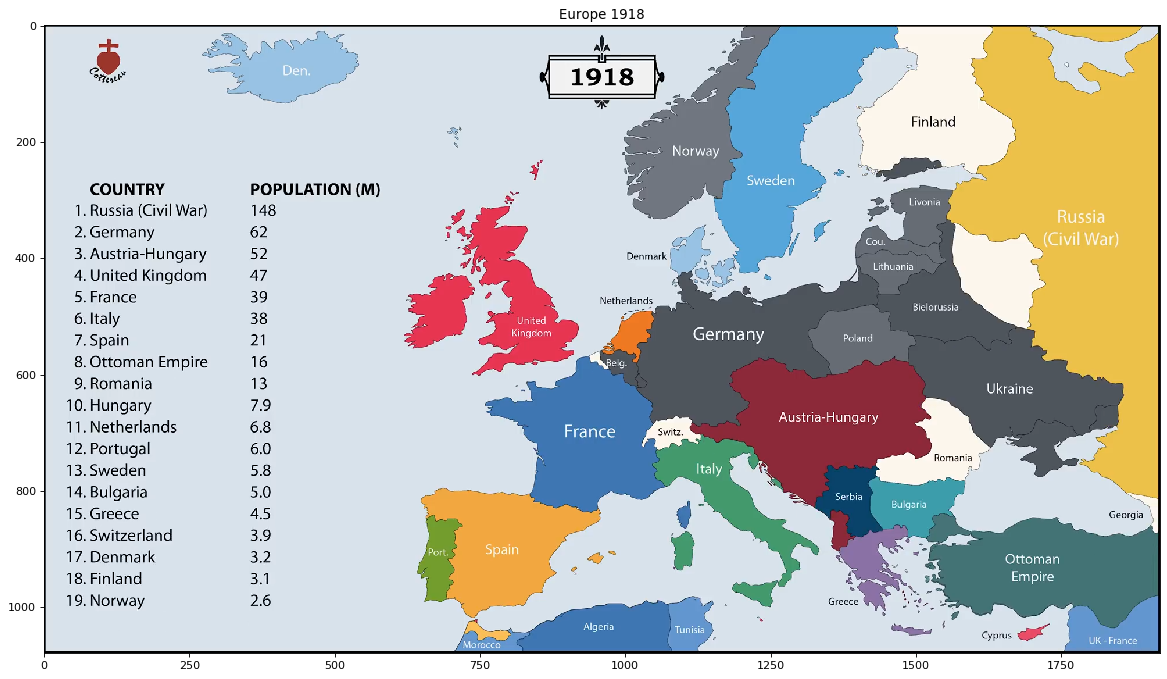

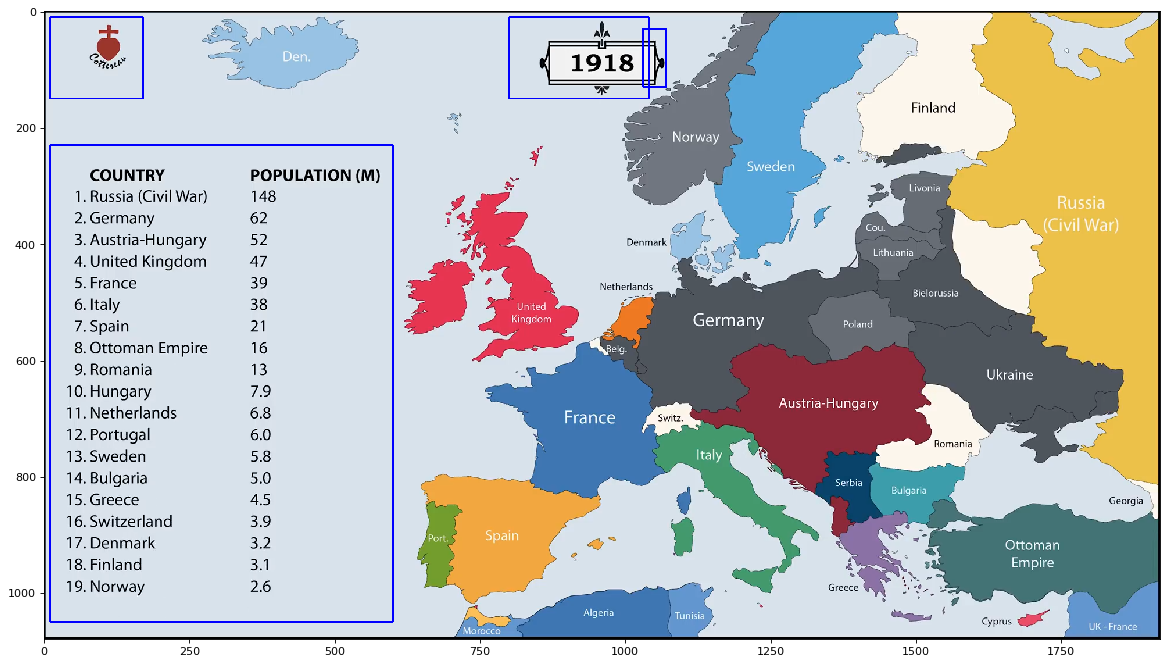

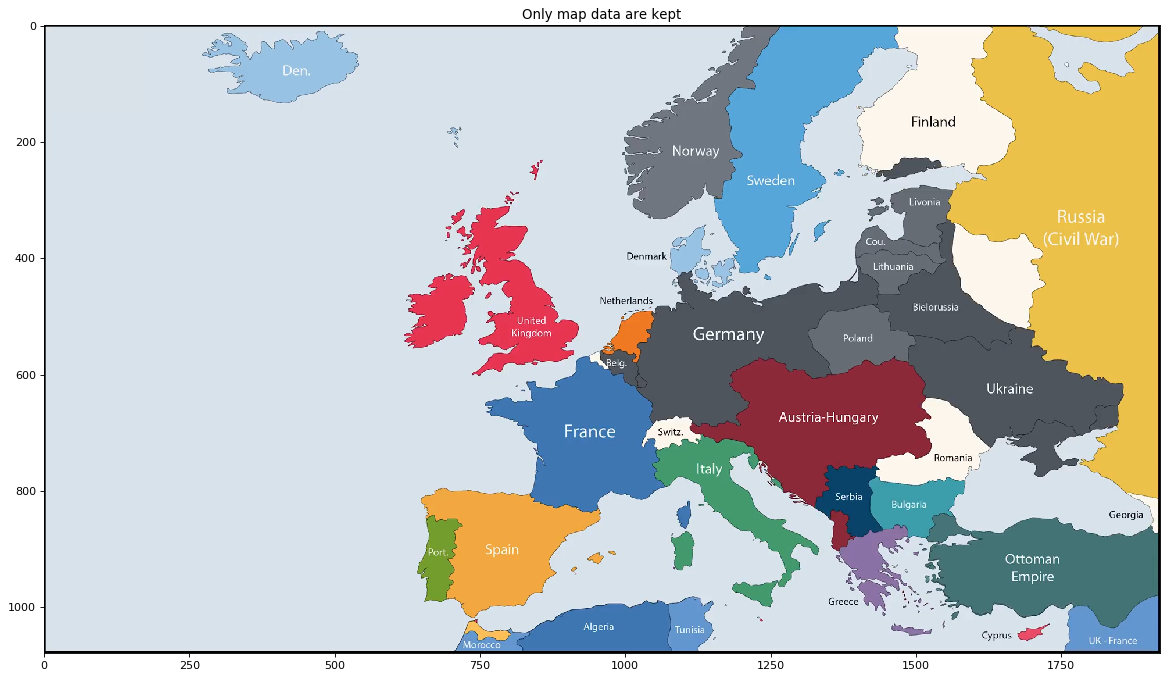

In [242]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage import color
from shapely.geometry import box
from skimage import transform

def display_img(img, title="", big=False) : 
    if big : 
        fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    plt.title(title)
    plt.imshow(img, cmap='gray')
    plt.show()

europe = color.rgba2rgb(plt.imread('input/europe_1918.png'))
display_img(europe, 'Europe 1918', True)

def disp_polygons(img, polygons, saveTo='') :
    todisp = img.copy()
    for polygon in polygons :
        (minx, miny, maxx, maxy) = np.array(polygon.bounds).astype(int)
        cv2.rectangle(todisp, (minx, miny), (maxx, maxy), (0, 0, int(np.max(todisp))), 2)
    display_img(todisp, '', True)
    if saveTo :
        plt.imsave(saveTo, todisp)
                      
def fill_polygons(img, polygons, fill_colors):
    res = img.copy()
    if np.ndim(fill_colors) == 1:
        fill_colors = [list(fill_colors)] * len(polygons)
    for i, polygon in enumerate(polygons) :
        [_, (xb, yb), _, (xa, ya), _] = [(int(x), int(y)) for (x, y) in polygon.exterior.coords]
        res[ya:yb, xa:xb] = fill_colors[i]
    return res
def display_colours(color_list) :
    size = len(color_list)
    plt.bar(range(size), [1]*size  , color=color_list)
    plt.show()

def get_surrounding_colors(img, polygon : box):
    offset = 1
    color_list = np.zeros((len(polygon.exterior.coords) , 3))
    x_left = int(np.array(polygon.exterior.coords)[:, 0].min()) - offset
    x_right = int(np.array(polygon.exterior.coords)[:, 0].max()) + offset
    y_top = int(np.array(polygon.exterior.coords)[:, 1].min()) - offset
    y_bottom = int(np.array(polygon.exterior.coords)[:, 1].max()) + offset
    corners =np.concatenate((
        img[y_top, x_left:x_right],
        img[y_bottom, x_left:x_right],
        img[y_top:y_bottom, x_left],
        img[y_top:y_bottom, x_right],
    ))
    res = np.median(corners, axis=0)
    return res
    
    
population_text_box = box(10, 230, 600, 1050)
logo_text_box = box(10, 10, 170, 150)
year_text_box_1 = box(800, 10, 1040, 150)
year_text_box_2 = box(1030, 30, 1070, 130)

to_remove = [population_text_box, logo_text_box, year_text_box_1, year_text_box_2]
surrounding_colors = [get_surrounding_colors(europe, box) for box in to_remove]
disp_polygons(europe, to_remove)

europe_cleaned = fill_polygons(europe, to_remove, surrounding_colors)
#europe_cleaned = transform.resize(europe_cleaned, (europe_cleaned.shape[0]/10, europe_cleaned.shape[1]/10))
display_img(europe_cleaned, 'Only map data are kept', True)

### 1.2. Remove countries' names


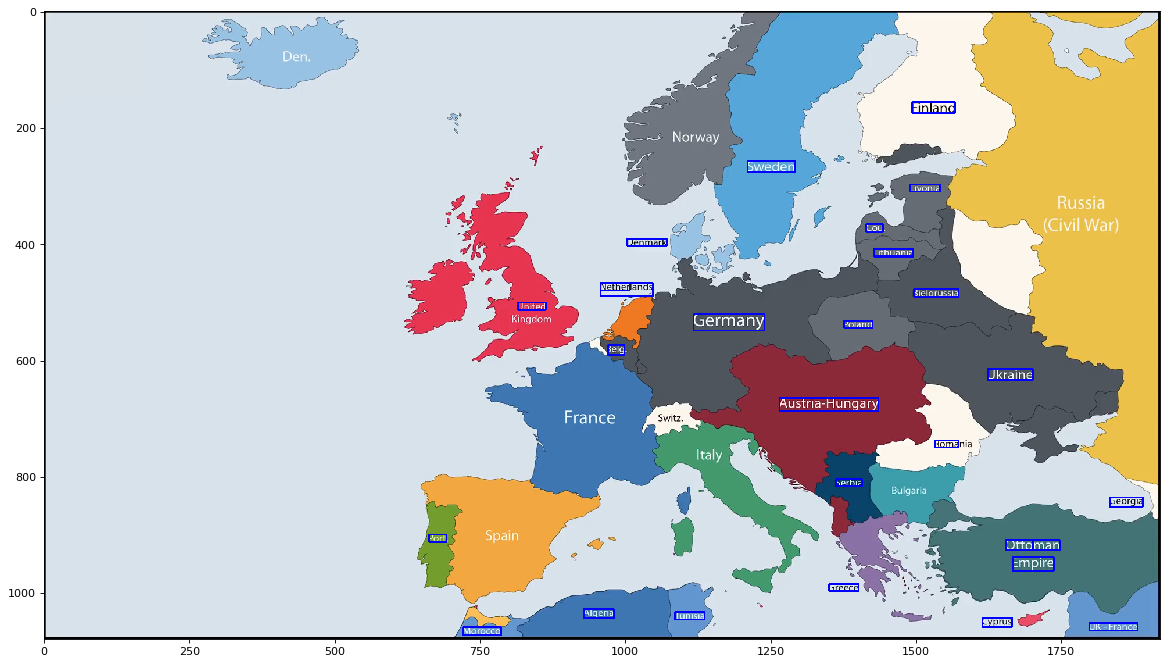

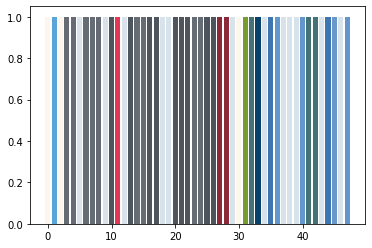

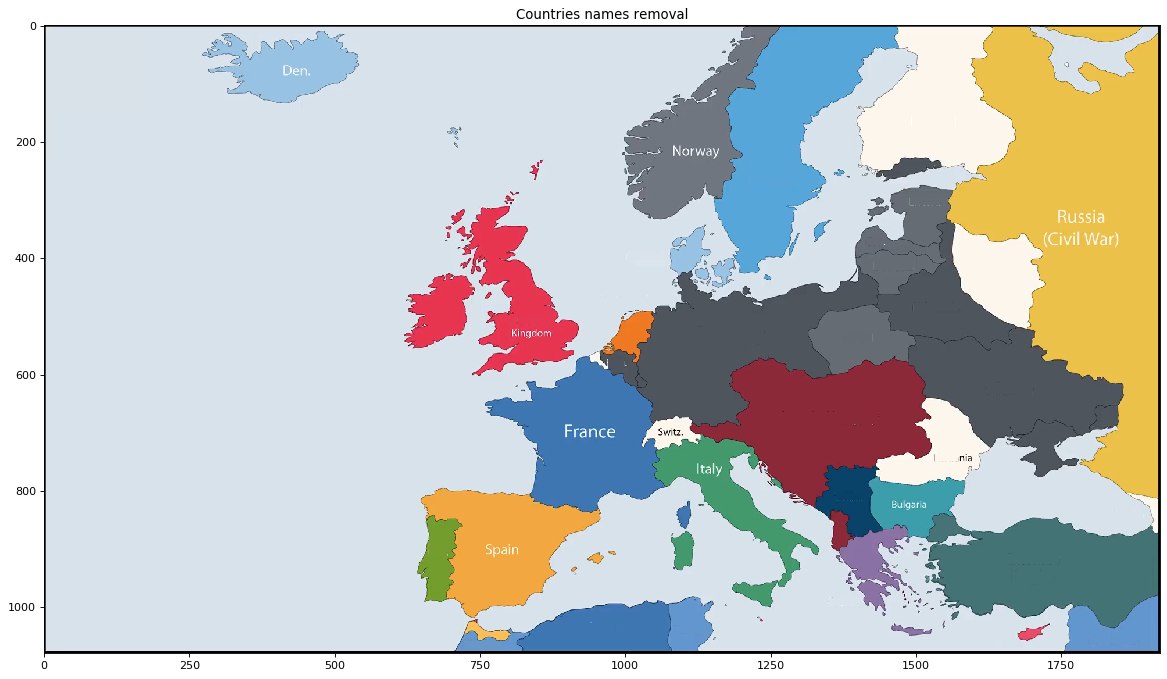

In [243]:
import pytesseract
import pandas as pd

from pytesseract import Output
from pprint import pprint
def filter_recognition_results(df):
    significantLetters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'
    authorizedLetters = significantLetters + "'-. ()"
    
    #At least 3 significant letters
    isLongEnough = lambda x : len([char for char in x if char in significantLetters]) >= 3
    noForbidden = lambda x : ''.join([char for char in x if char in authorizedLetters]) == x
    # Removing empty
    validity_array = [isLongEnough(row['text']) and noForbidden(row['text']) for _, row in df.iterrows()]
    return df[validity_array]
    
def apply_tesseract(img) :
    plt.imsave('tmp/tesseract_input_gray.png', color.rgb2gray(img), cmap='gray')
    d = pytesseract.image_to_data('tmp/tesseract_input_gray.png', config="--oem 3 --psm 11",lang='eng', output_type=Output.DICT)
    plt.imsave('tmp/tesseract_input_color.png', img, cmap='gray')
    d_color = pytesseract.image_to_data('tmp/tesseract_input_color.png', config="--oem 3 --psm 11",lang='eng', output_type=Output.DICT)
    boxes = []
    bboxes = pd.DataFrame(columns=['bbox'])
    df = filter_recognition_results(pd.DataFrame(d))
    df = df.append(filter_recognition_results(pd.DataFrame(d_color)))
    for i, row in df.iterrows():
        (x, y, w, h) = (row['left'], row['top'], row['width'], row['height'])
        boxes.append(box(x, y, x+w, y+h))
        bboxes.loc[i] =  [box(x, y, x+w, y+h)]
    disp_polygons(img, bboxes['bbox'].values)
    return bboxes.join(df.text).reset_index()

countries_names = apply_tesseract(europe_cleaned )

# Text removal when possible
fill_colors = [get_surrounding_colors(europe_cleaned, bbox) for bbox in countries_names['bbox'].values]
display_colours(fill_colors)
europe_cleaned = fill_polygons(europe_cleaned , countries_names['bbox'].values , fill_colors)
display_img(europe_cleaned, 'Countries names removal', True)

## 2. Keep only the relevant colors

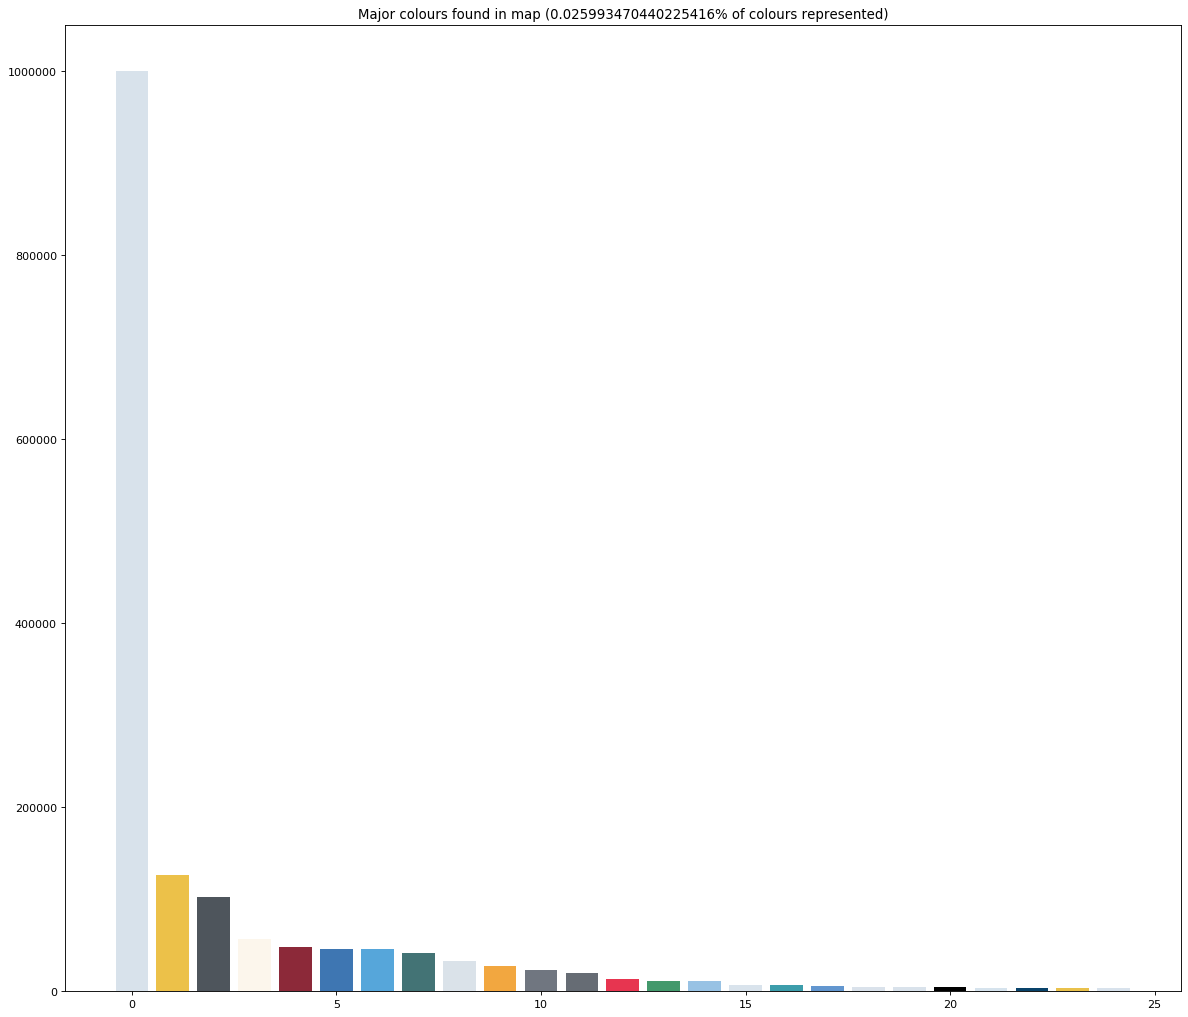

In [244]:
def extract_major_colors(img) :
    unique, counts = np.unique(img.reshape(int(img.size/3), 3), axis=0, return_counts=True)
    scores = list(zip(counts, unique))
    df = pd.DataFrame(scores, columns=['count', 'value']).sort_values(by=['count'], ascending=False)
    return df
def print_colors(extracted_colors):
    toplot = extracted_colors[:25]
    percentage = 100 * len(toplot)/len(extracted_colors)
    fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    plt.bar(np.arange(len(toplot)) , toplot['count'].values , color=toplot['value'].values)
    plt.title('Major colours found in map ('+str(percentage)+'% of colours represented)')
    plt.show()
extracted =  extract_major_colors(europe_cleaned)
print_colors(extracted)

As displayed above, the image contains way too many colours. If we plan to extract countries based on colours, we'll first have to regroup these colours to make sense.  
This cane be done with the following clustering algorithm

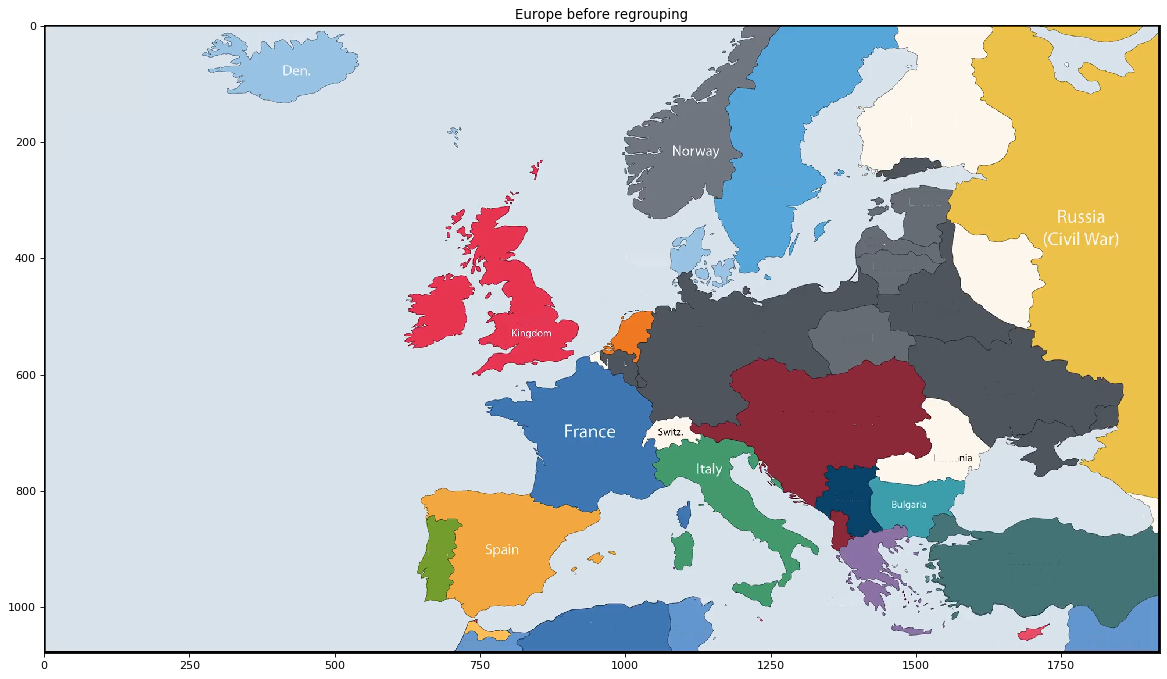

CPU times: user 9.47 s, sys: 48.5 ms, total: 9.52 s
Wall time: 8.63 s


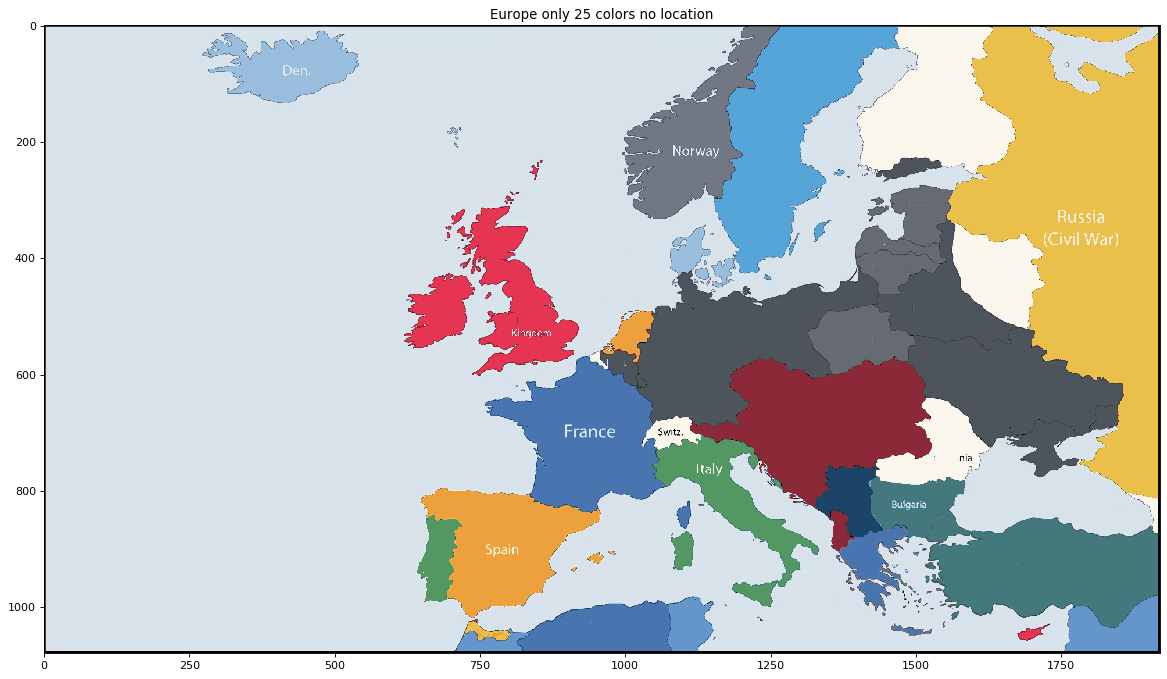

In [245]:
from sklearn.cluster import MiniBatchKMeans
def regroup_colors(image, nb_color, include_location=True) :
    (h, w) = image.shape[:2]
    data = image.copy()
    # Lab is a colour representation (l, a , b). 
    #It is made so that if (l, a , b) differs numerically, the perceived colour by humans will also differ
    data = color.rgb2lab(data)
    #Adding location
    if include_location :
        col_num = (np.arange(w)/w * 100).reshape((1, w)).repeat(h, axis=0).reshape((h, w, 1))
        row_num = (np.arange(h)/h * 100).repeat(w).reshape((h, w, 1))
        data = np.c_[data, row_num, col_num]
    
    #With location added, kmeans
    data = data.reshape((h*w, 5 if include_location else 3))
    clt = MiniBatchKMeans(n_clusters = nb_color, random_state = 0)
    labels = clt.fit_predict(data)
    res = clt.cluster_centers_[labels].reshape((h, w, 5 if include_location else 3))
    if include_location :
        #removing location info
        res = res[:, :, :3]
    res = color.lab2rgb(res)
    return res

def exploreLAB(labimg):
    l = labimg[:, :, 0].flatten()
    a = labimg[:, :, 1].flatten()
    b = labimg[:, :, 2].flatten()
    plt.hist(l, bins=100)
    plt.hist(a, bins=100)
    plt.hist(b, bins=100)
    plt.show()
nb_color = 25
display_img(europe_cleaned, "Europe before regrouping", True)
#exploreLAB(color.rgb2lab(europe_cleaned))
#%time clustered_europe = regroup_colors(europe_cleaned, nb_color, True)
#display_img(clustered_europe, "Europe only "+str(nb_color)+" colors  with location", True)
%time clustered_europe_no_location = regroup_colors(europe_cleaned, nb_color, False)
display_img(clustered_europe_no_location, "Europe only "+str(nb_color)+" colors no location", True)

Now, the colour count has a meaning

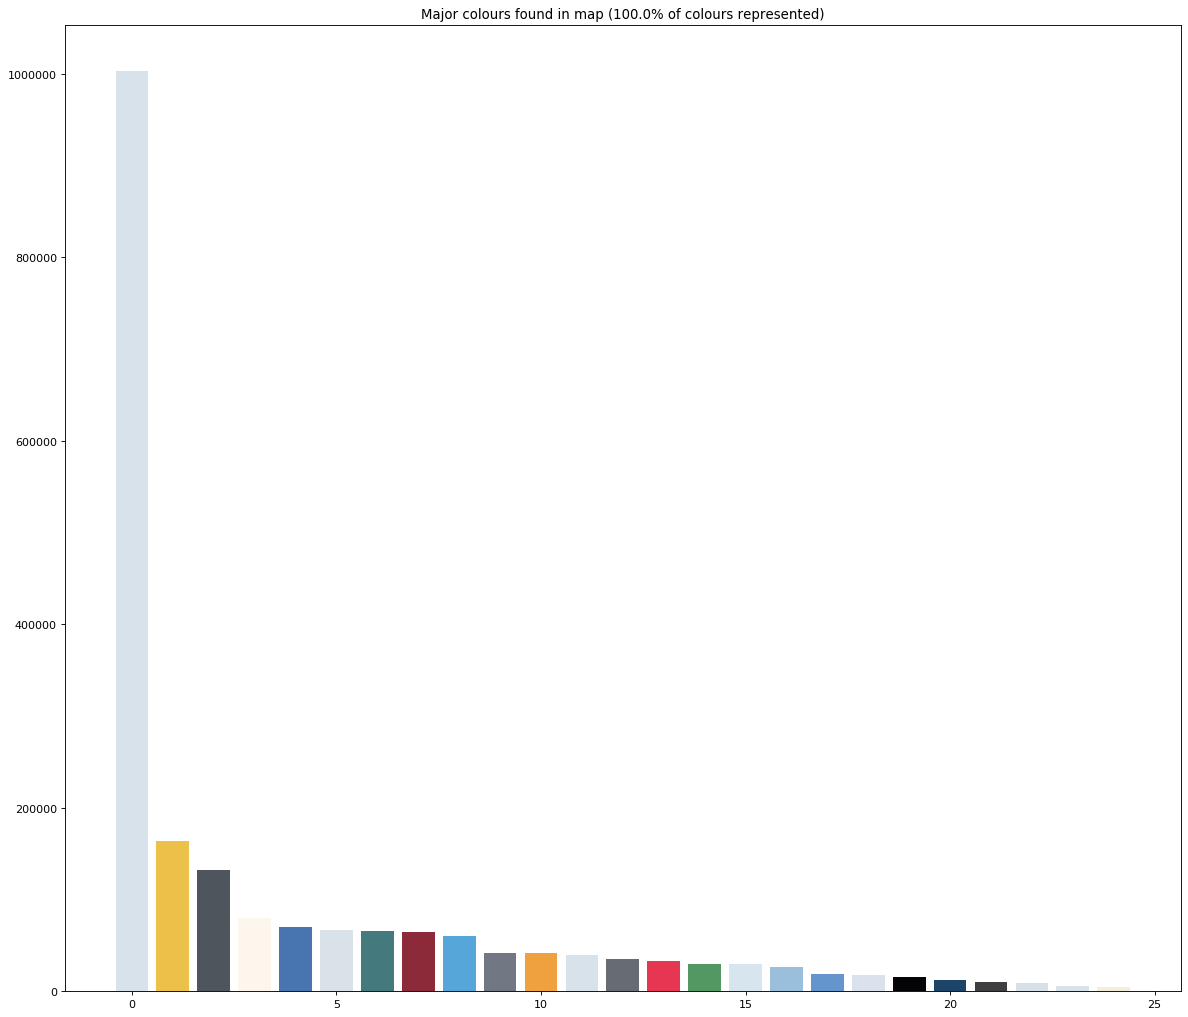

In [246]:
extracted_colors =  extract_major_colors(clustered_europe_no_location)
print_colors(extracted_colors)

## Country extraction with a mask
Assuming colours exactly define the country, a mask can be applied to extract the country's borders


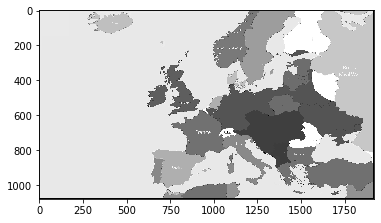

[0.88048595 0.75775857 0.32893812 0.96705029 0.43956517 0.88122456
 0.43336201 0.25028259 0.59876584 0.47000842 0.66753666 0.88067841
 0.42004555 0.36596318 0.5246353  0.88897743 0.72621231 0.56021536
 0.88231106 0.01176583 0.24282338 0.24479859 0.87264148 0.88049058
 0.93055508]


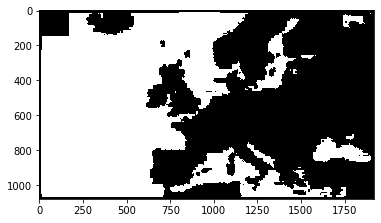

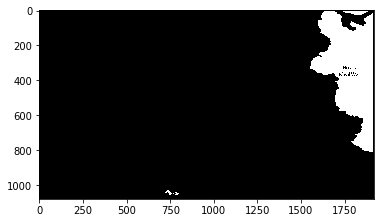

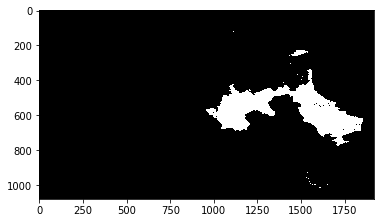

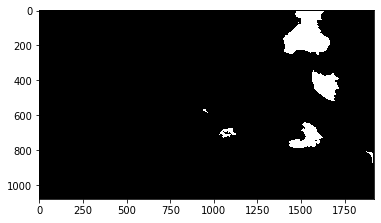

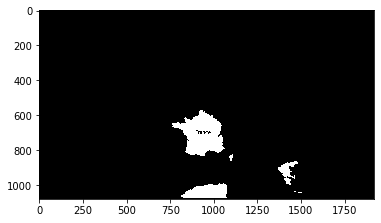

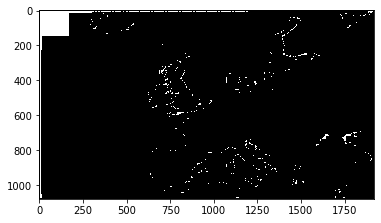

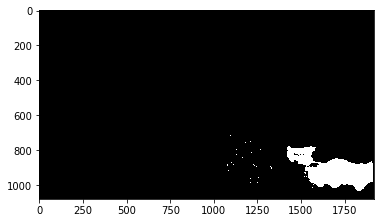

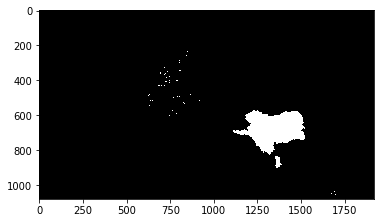

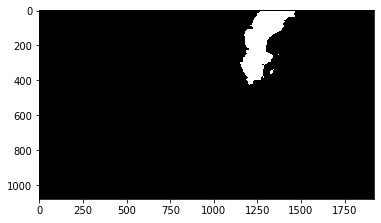

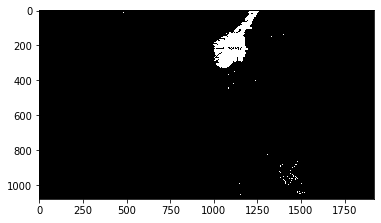

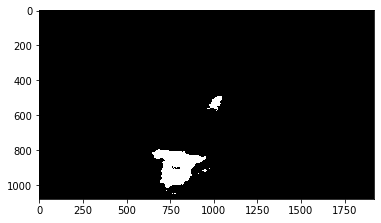

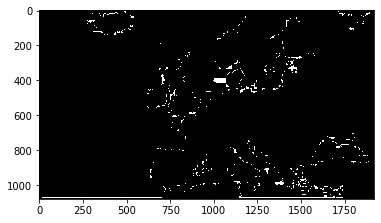

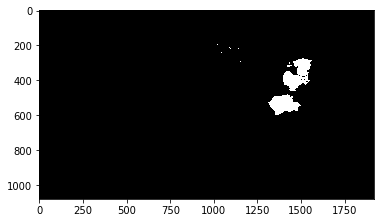

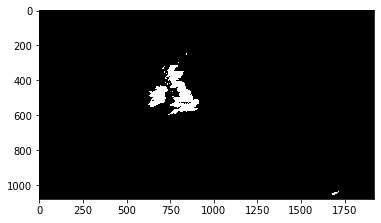

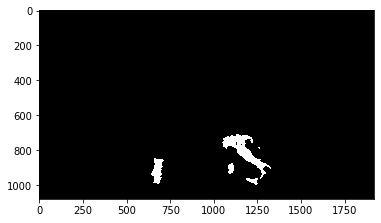

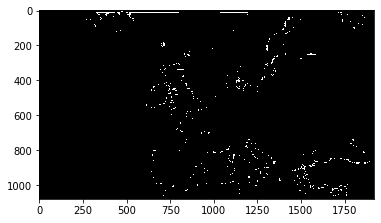

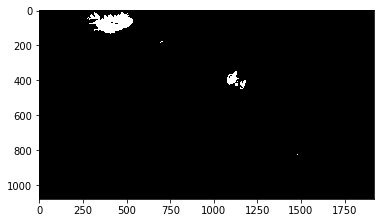

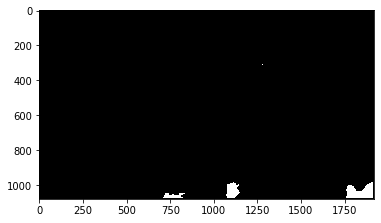

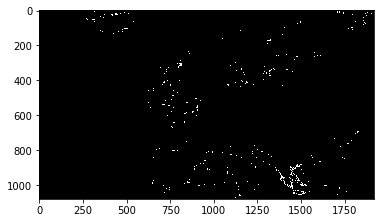

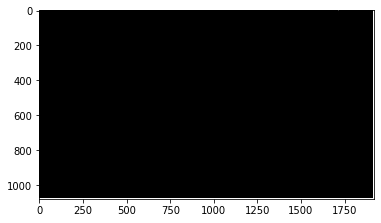

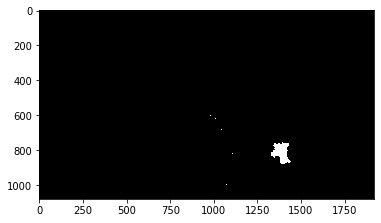

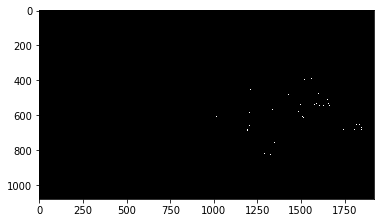

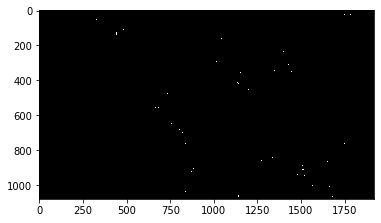

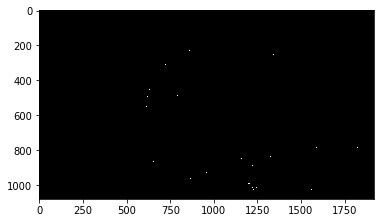

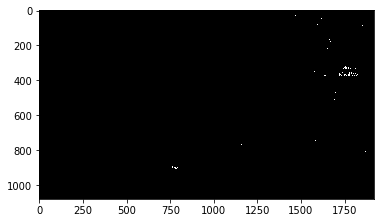

In [247]:
from skimage.filters.rank import median

def get_masked(source_img, colour):
    h, w = source_img.shape[:2]
    return source_img==colour
def noise_reduction(img) : 
    return median(img, selem=np.ones((3, 3)))

grayscale_europe = color.rgb2gray(clustered_europe_no_location)
grayscale_major_colors = color.rgb2gray(np.concatenate(extracted_colors['value'].values).reshape((len(extracted_colors), 1, 3))).flatten()
#display_img(grayscale_europe, 'Europe grayscale')
#display_img(grayscale_major_colors, 'Colors in europe', True)
masks = []
display_img(grayscale_europe)
print(grayscale_major_colors)
for col in grayscale_major_colors:
    mask = get_masked(grayscale_europe,col)
    masks.append(mask)
masks = [noise_reduction(mask) for mask in masks]

for mask in masks :
    display_img(mask)
#    mask_rgb = np.repeat(mask, 3).reshape(europe.shape)
 #   display_img(np.where(mask_rgb, europe, np.ones(europe_cleaned.shape)), "One color extraction", True)


Let's consider France

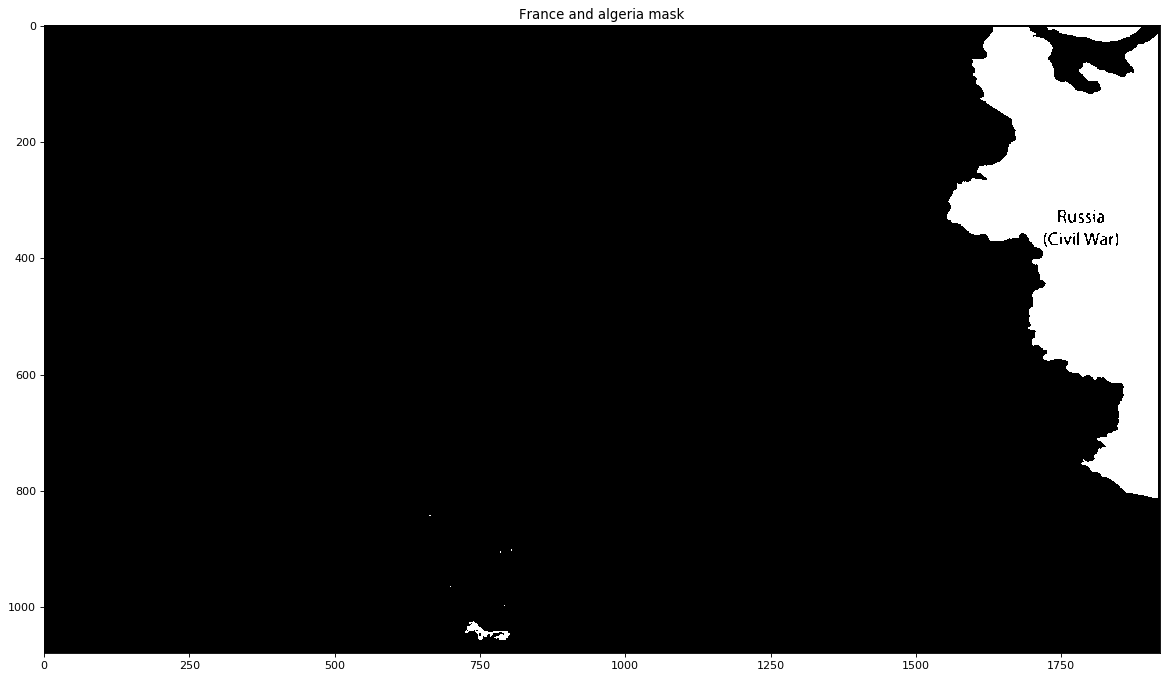

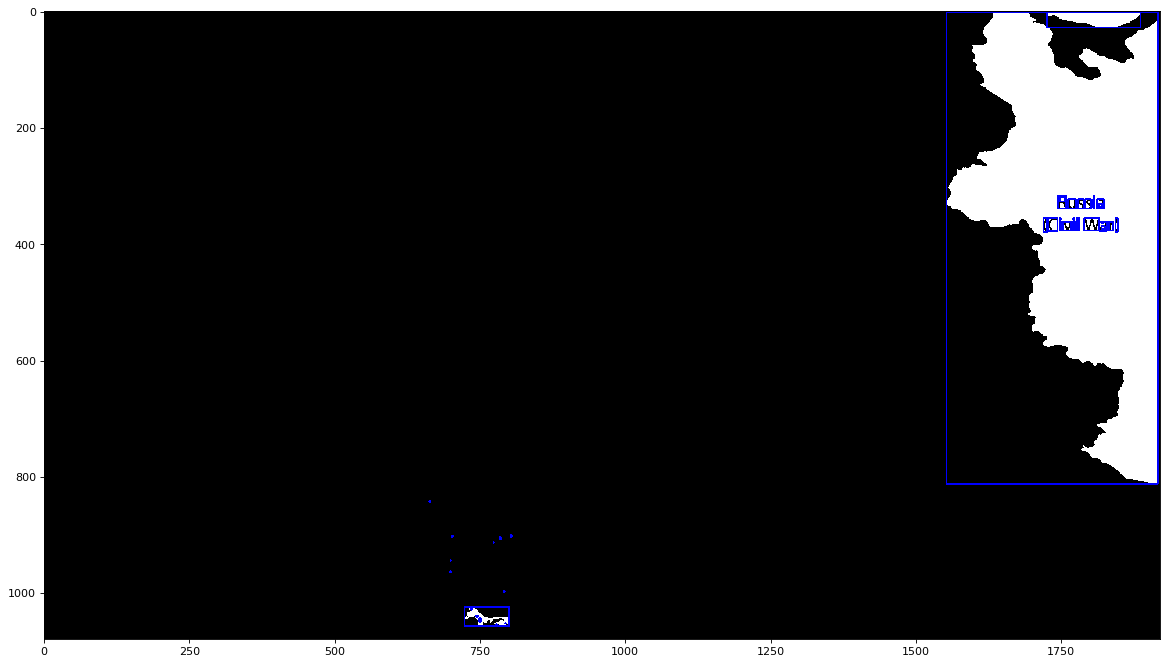

In [256]:
from skimage import measure
from shapely.geometry import Polygon
import skimage.color
def get_polygons(mask):
    contours = measure.find_contours(mask, 0.8)
    return [Polygon(list(zip(contour[:, 1], contour[:, 0]))) for contour in contours]

def drawShape(img, coordinates, color) :
    # In order to draw our line in red
    img = skimage.color.gray2rgb(img)

    # Make sure the coordinates are expressed as integers
    coordinates = coordinates.astype(int)

    img[coordinates[:, 0], coordinates[:, 1]] = color

    return img

fr_mask = masks[1]
display_img(fr_mask, 'France and algeria mask', True)
disp_polygons(skimage.color.gray2rgb(fr_mask), get_polygons(fr_mask))

That's a lot of polygons. The number of polygons can be reduced if letters and too small polygons are removed


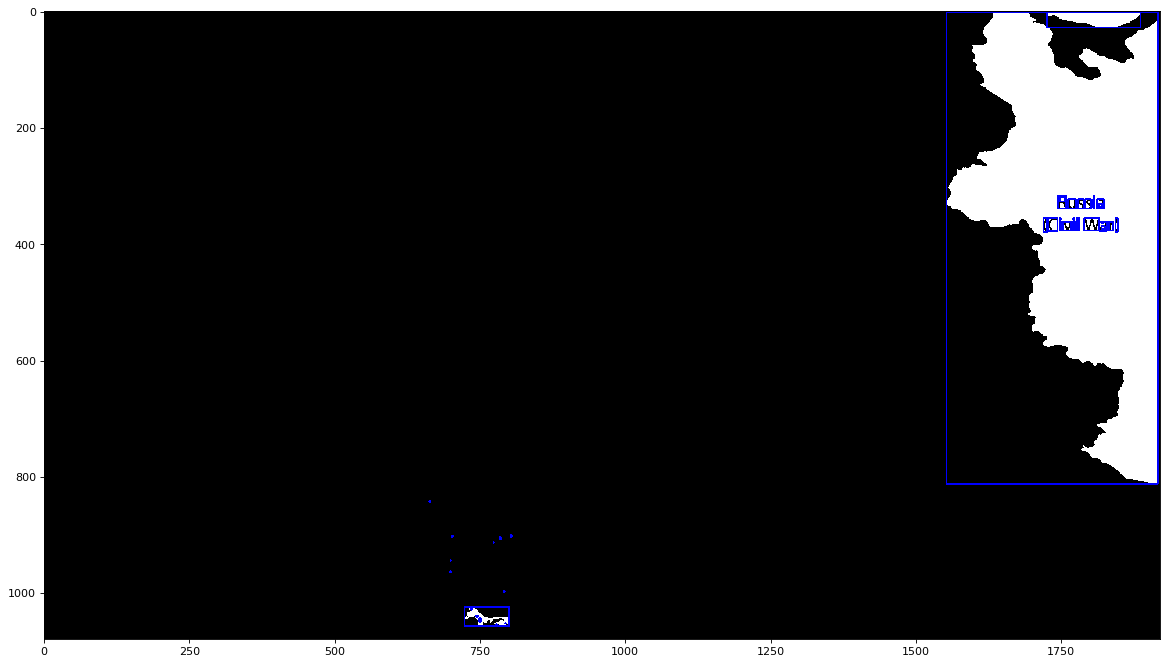

score 0.9802611075730682
score 0.9257047300525562
score 0.38636363636363635
score 0.2916666666666667
score 0.23076923076923078
score 0.30288461538461536
score 0.898465171192444


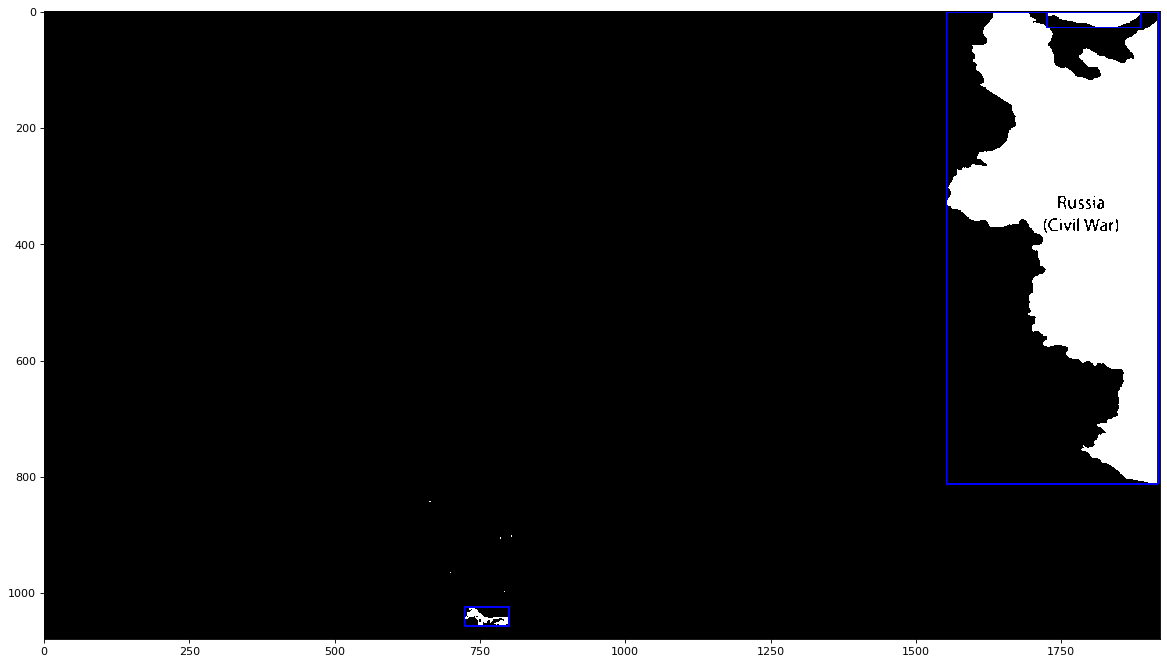

Kept  3 polygons


In [260]:
import skimage.draw
def is_letter(polygon, mask):
    (minx, miny, maxx, maxy) = np.array(polygon.bounds).astype(int)
    area = mask[miny:maxy , minx:maxx].copy()
    area[area!=0] = 1
    #display_img(area)
    coords = np.array(polygon.exterior.coords)
    rr, cc = skimage.draw.polygon(coords[:, 1], coords[:, 0])
    overlay = np.zeros(area.shape)
    overlay[rr-miny-1, cc-minx-1] = 1
    #display_img(overlay)
    
    matching = area==overlay
    #display_img(matching)
    score = np.count_nonzero(matching)/matching.size
    print('score', score)
    return score < 0.5

def is_big_enough(polygon):
    return polygon.area > 100

def is_significant(polygon, mask):
    return is_big_enough(polygon) and not is_letter(polygon, fr_mask)

def filter_polygons(polygons, mask):
    return [polygon for polygon in polygons if is_significant(polygon, mask)]

found_poly = get_polygons(fr_mask)
disp_polygons(color.gray2rgb(fr_mask), found_poly)
kept_polygons = filter_polygons(found_poly, fr_mask)
disp_polygons(skimage.color.gray2rgb(fr_mask), kept_polygons)
print('Kept ', len(kept_polygons), 'polygons')

Now for every map

score 0.32992697826847817
score 0.23958333333333334
score 0.25956756756756755
score 0.7318961157604529
score 0.29184188393608074
score 0.28348348348348346
score 0.23125
score 0.4094761171032357
score 0.04081632653061224
score 0.2857142857142857
score 0.2565789473684211
score 0.47767857142857145
score 0.48016101207590567
score 0.3041958041958042
score 0.7443814047587632
score 0.6586755076294605
score 0.42142857142857143
score 0.32871794871794874
score 0.5088023088023088
score 0.17148760330578514
score 0.4651639344262295
score 0.2532051282051282
score 0.1375


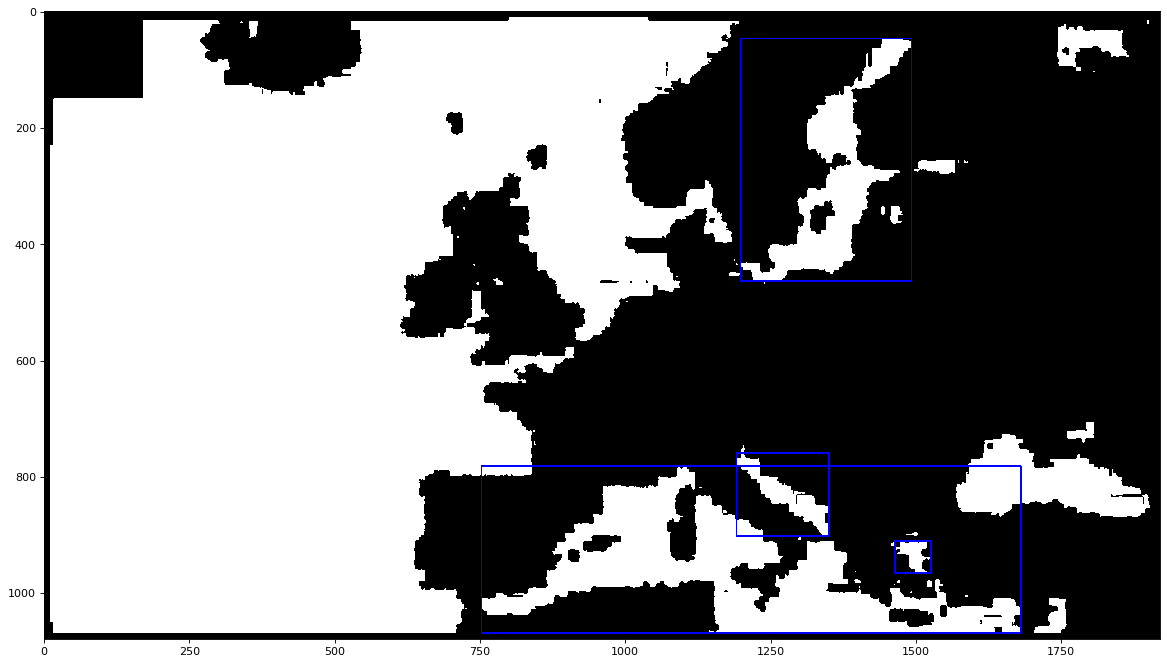

Kept  4 polygons
score 0.9802611075730682
score 0.9257047300525562
score 0.38636363636363635
score 0.2916666666666667
score 0.23076923076923078
score 0.30288461538461536
score 0.898465171192444


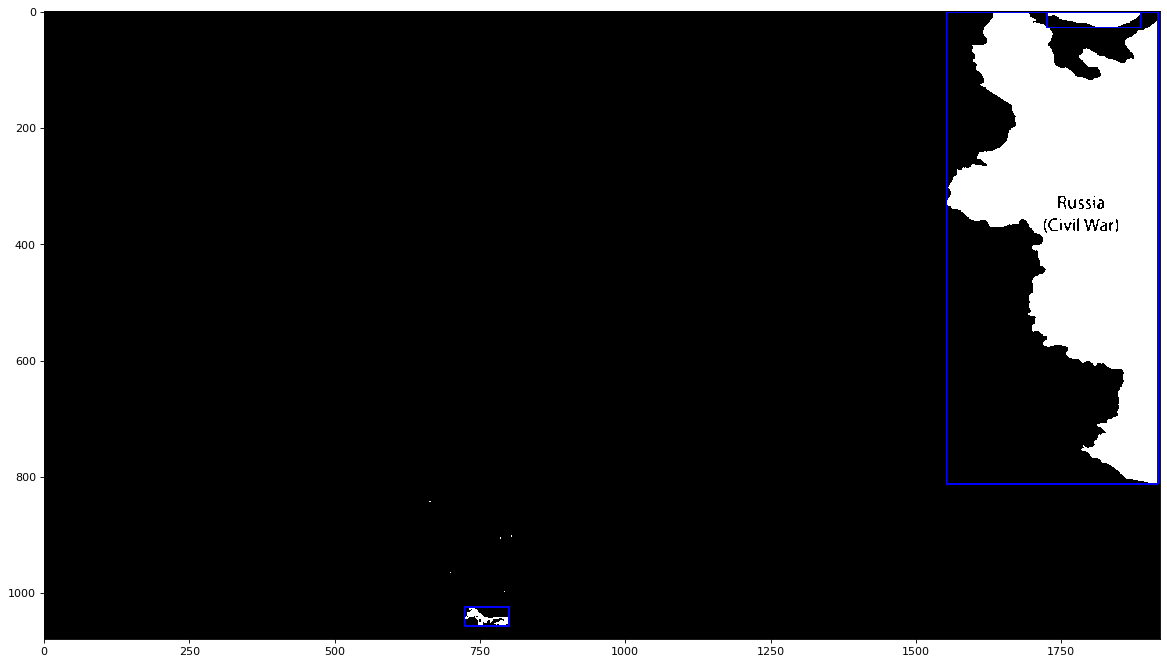

Kept  3 polygons
score 0.5435435435435435
score 0.5693102944951404
score 0.40384615384615385
score 0.6728110599078341


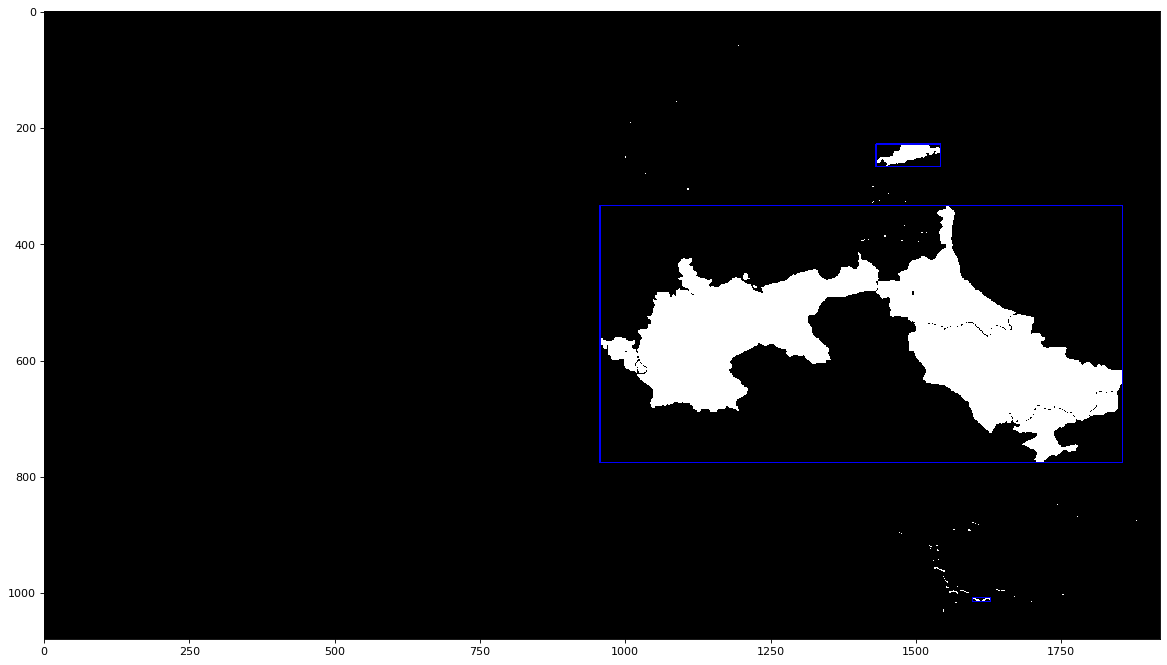

Kept  3 polygons
score 0.22077789449112978
score 0.19333851919949085
score 0.6566820276497696
score 0.4981889105600446
score 0.43403790087463556
score 0.4592760180995475
score 0.4405594405594406
score 0.6611888111888112


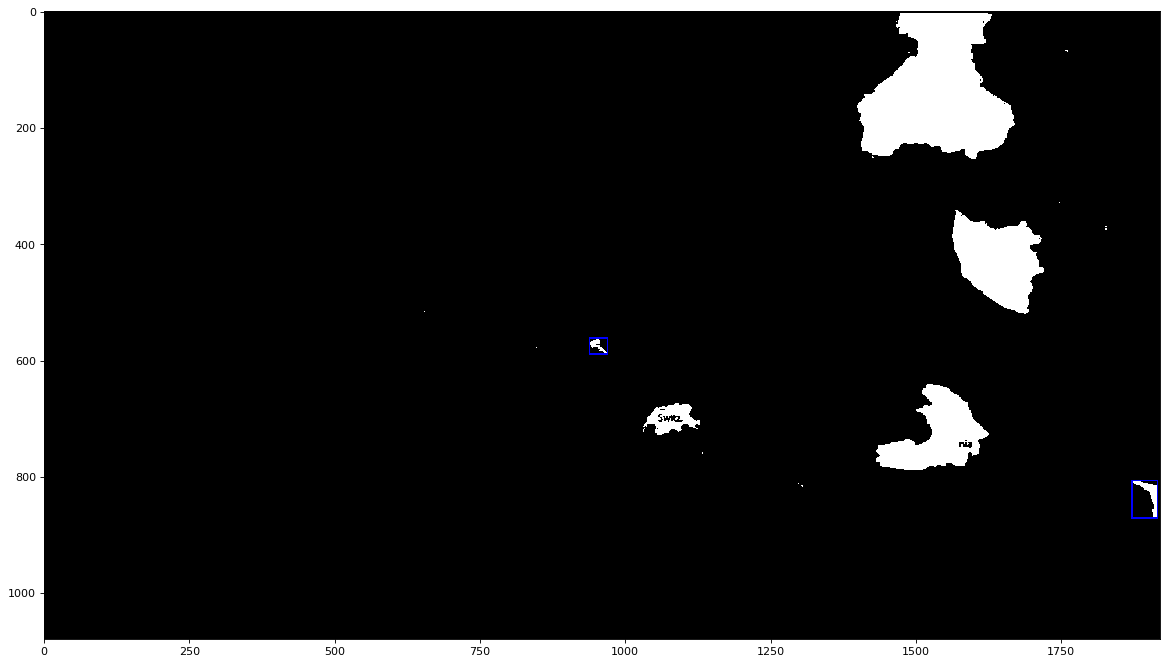

Kept  2 polygons
score 0.43866583708475154
score 0.248868778280543
score 0.36470588235294116
score 0.37913223140495866
score 0.5586120401337793
score 0.4231601731601732
score 0.24207975324961445
score 0.3774193548387097


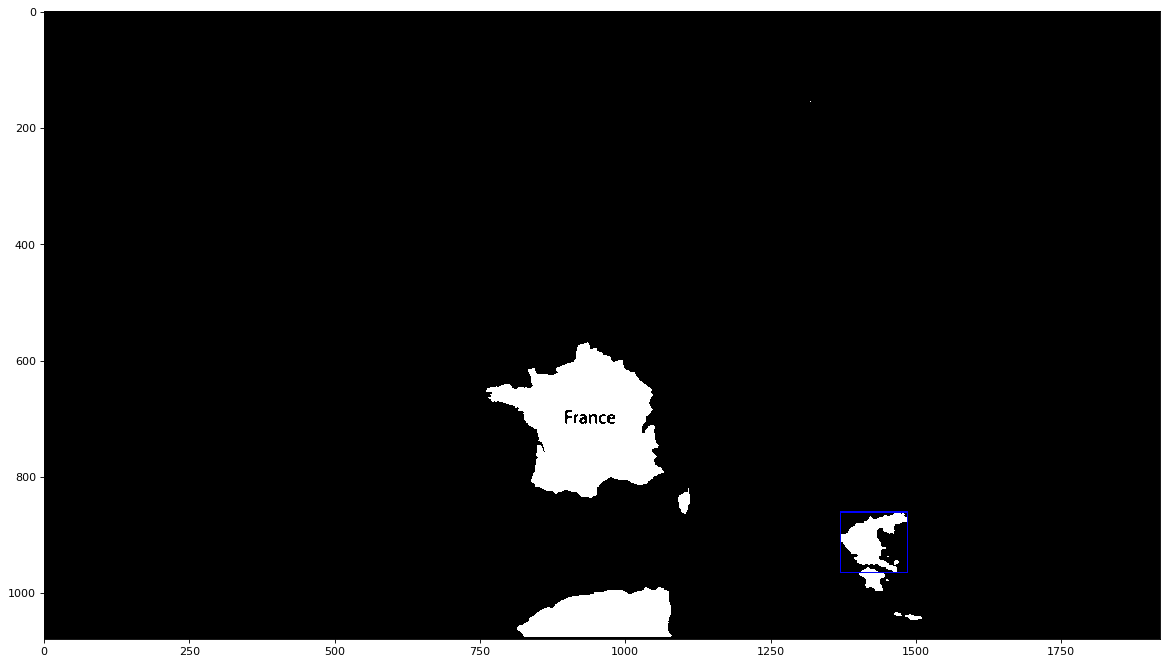

Kept  1 polygons
score 0.9504409225005418
score 0.19228094575799723
score 0.5473684210526316
score 0.3138888888888889
score 0.3401360544217687
score 0.3383458646616541
score 0.5277777777777778
score 0.2222222222222222
score 0.3106060606060606
score 0.8726655348047538
score 0.5476190476190477
score 0.6811594202898551
score 0.3333333333333333
score 0.4820936639118457
score 0.23232323232323232
score 0.6526806526806527
score 0.5175
score 0.5410628019323671
score 0.5848214285714286
score 0.40559440559440557
score 0.08333333333333333
score 0.6947261663286004
score 0.6755852842809364
score 0.37890625
score 0.6023391812865497
score 0.5880681818181818
score 0.46130952380952384
score 0.6574074074074074
score 0.5800865800865801
score 0.4727272727272727
score 0.5784313725490197
score 0.2708333333333333
score 0.6904761904761905
score 0.3333333333333333
score 0.4935064935064935
score 0.6026315789473684
score 0.03571428571428571
score 0.5161290322580645
score 0.6309523809523809
score 0.51733333333333

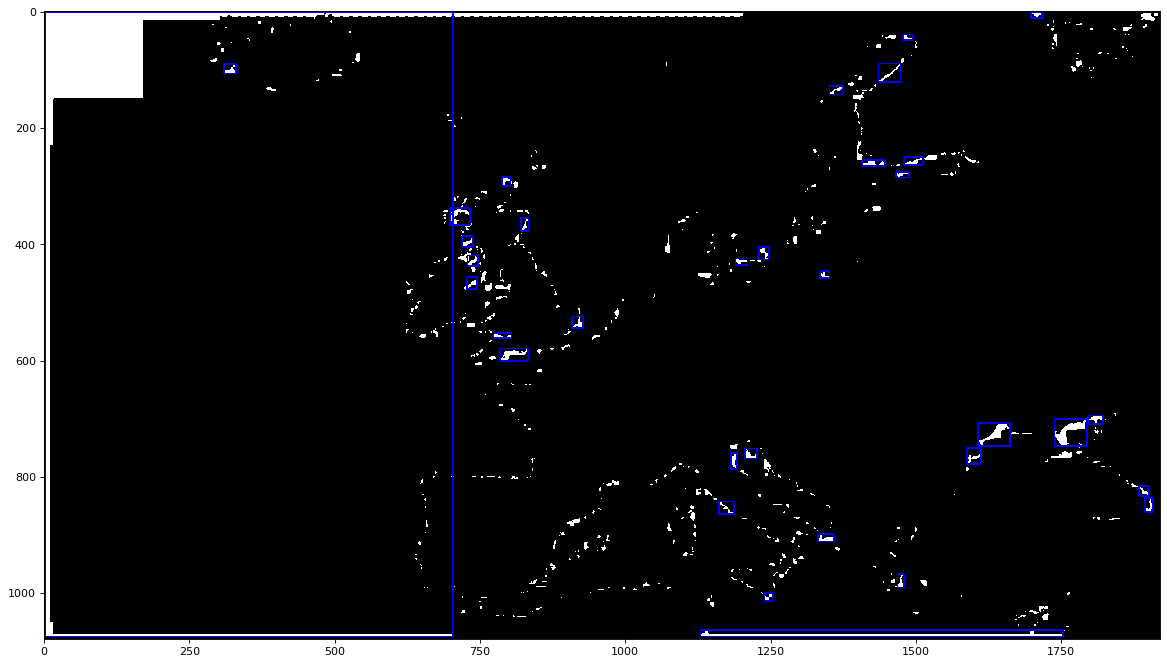

Kept  34 polygons
score 0.4871104871104871
score 0.4365079365079365
score 0.5266106442577031


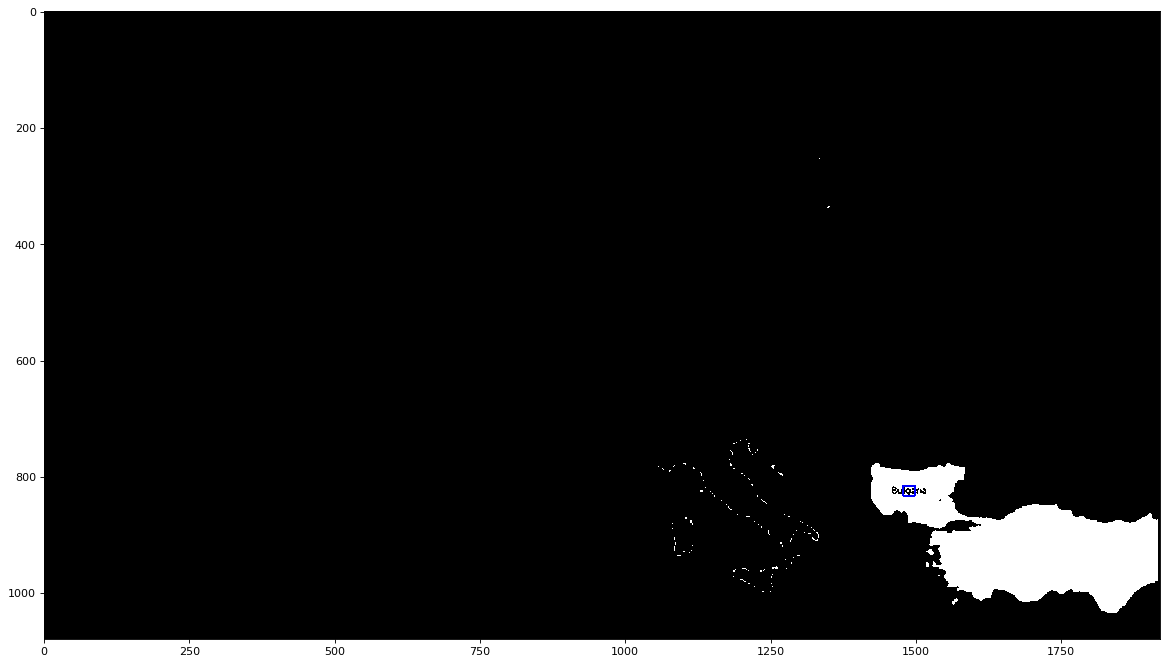

Kept  1 polygons
score 0.45260887909615116
score 0.4255920820077766


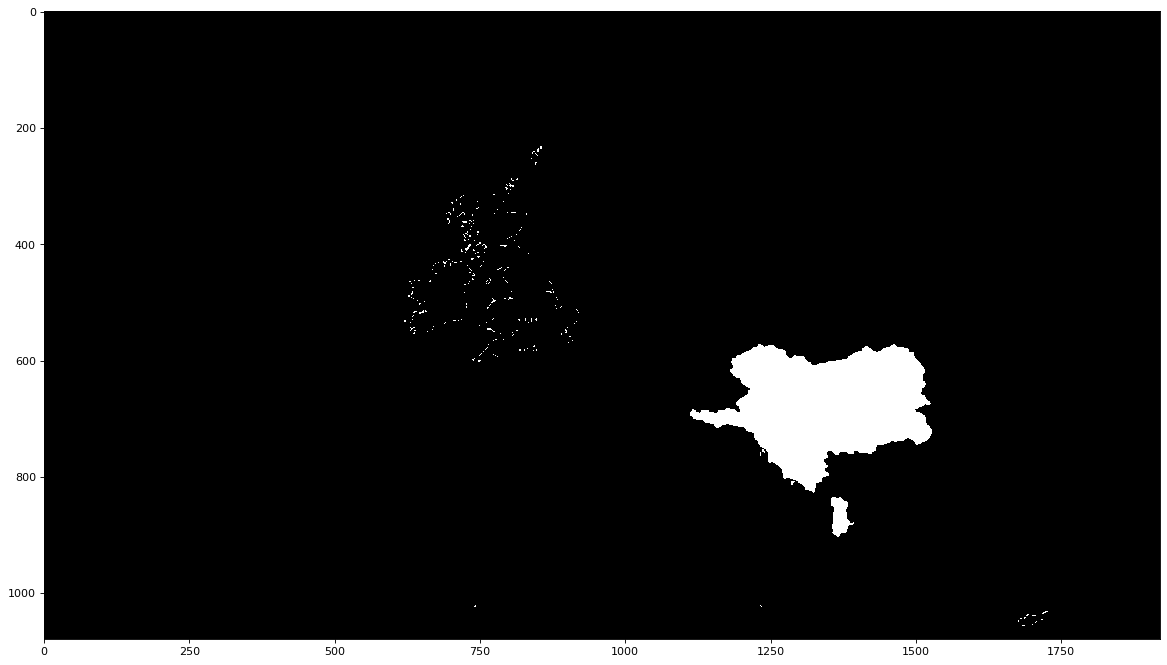

Kept  0 polygons
score 0.5488085856880183
score 0.44548872180451127


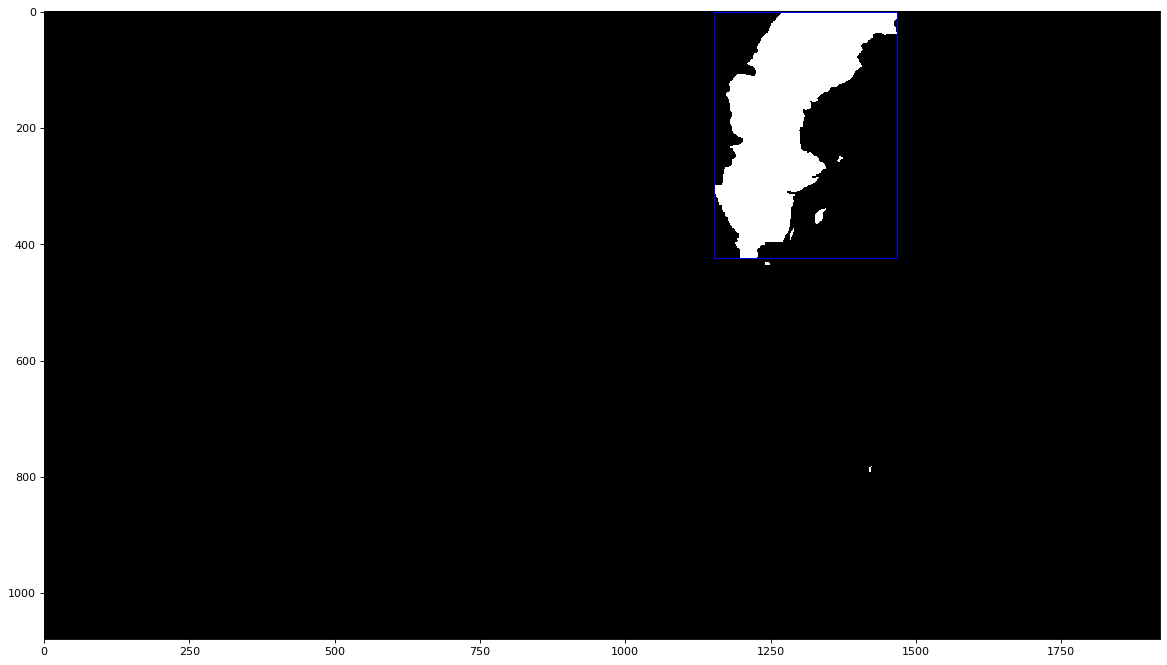

Kept  1 polygons
score 0.60892002734108
score 0.44096728307254623
score 0.31221719457013575
score 0.5555555555555556


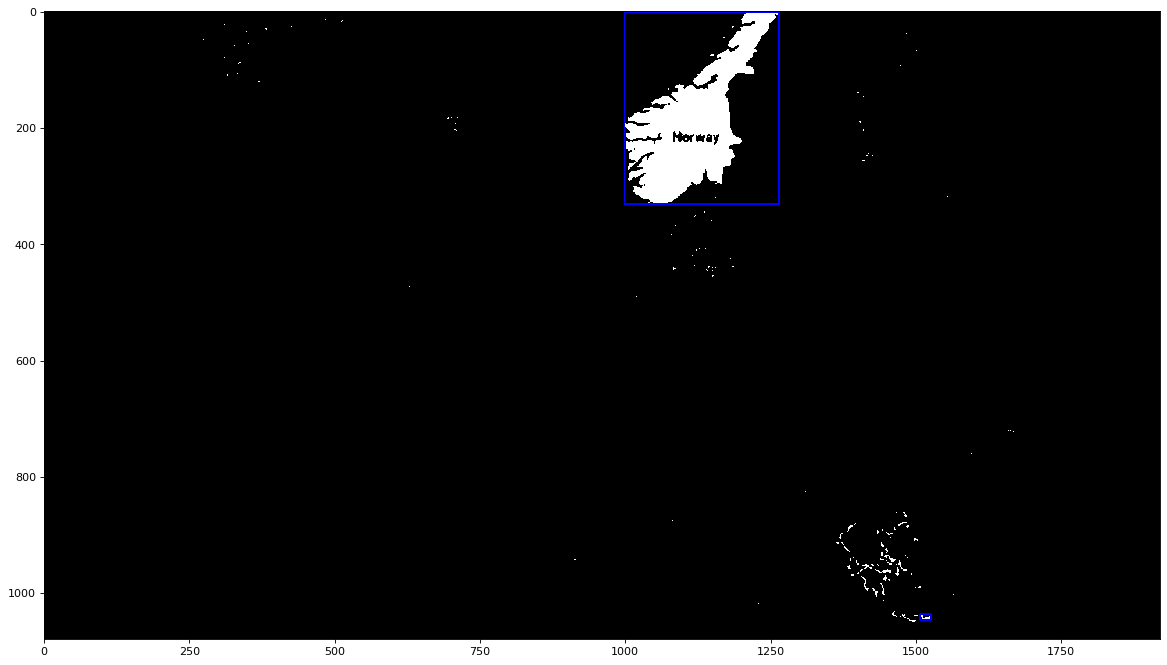

Kept  2 polygons
score 0.5361807732497388
score 0.46120878159713113
score 0.4673684210526316
score 0.4288888888888889
score 0.27380952380952384


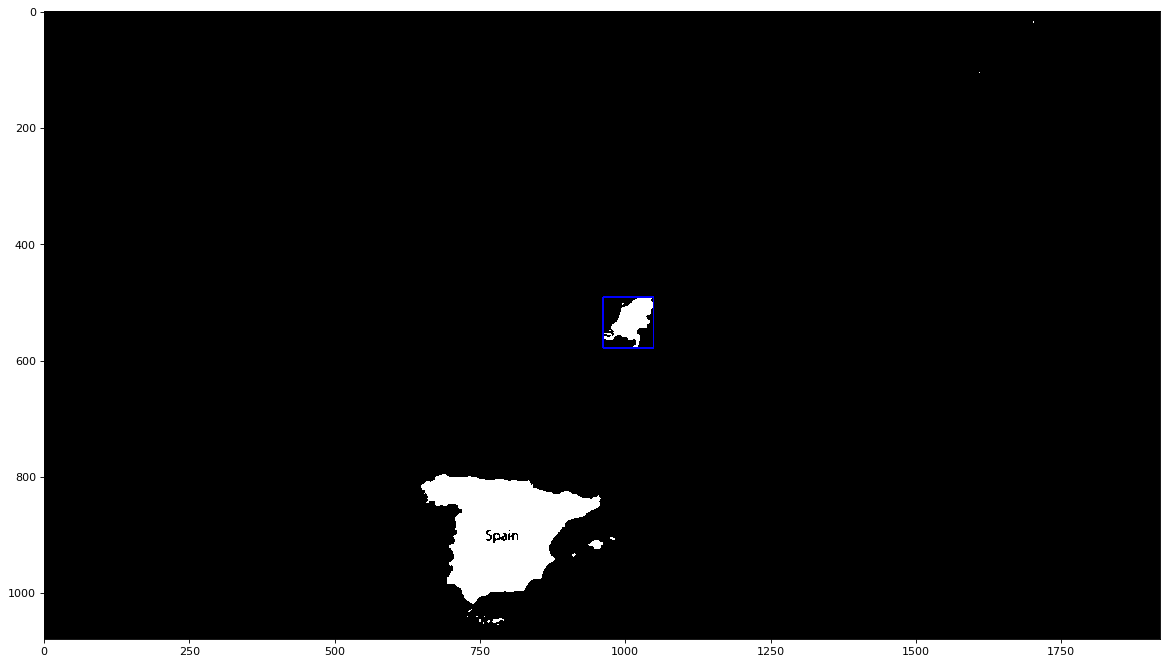

Kept  1 polygons
score 0.6885245901639344
score 0.4479717813051146
score 0.6933333333333334
score 0.6055555555555555
score 0.41333333333333333
score 0.5308510638297872
score 0.5313390313390314
score 0.44805194805194803
score 0.4532258064516129
score 0.6765151515151515
score 0.3954248366013072
score 0.5204081632653061
score 0.5148148148148148
score 0.5164835164835165
score 0.7505882352941177
score 0.4025974025974026
score 0.13333333333333333
score 0.6328125
score 0.47866419294990725
score 0.6794871794871795
score 0.7048872180451128
score 0.5042016806722689
score 0.7416666666666667
score 0.6879535558780842
score 0.5656108597285068
score 0.6459627329192547
score 0.7142857142857143
score 0.35064935064935066
score 0.64375
score 0.7944444444444444
score 0.4947839046199702
score 0.4965034965034965
score 0.4323308270676692
score 0.49264705882352944
score 0.32679738562091504
score 0.3466666666666667
score 0.7409523809523809
score 0.5586734693877551
score 0.6142857142857143
score 0.5904761904761

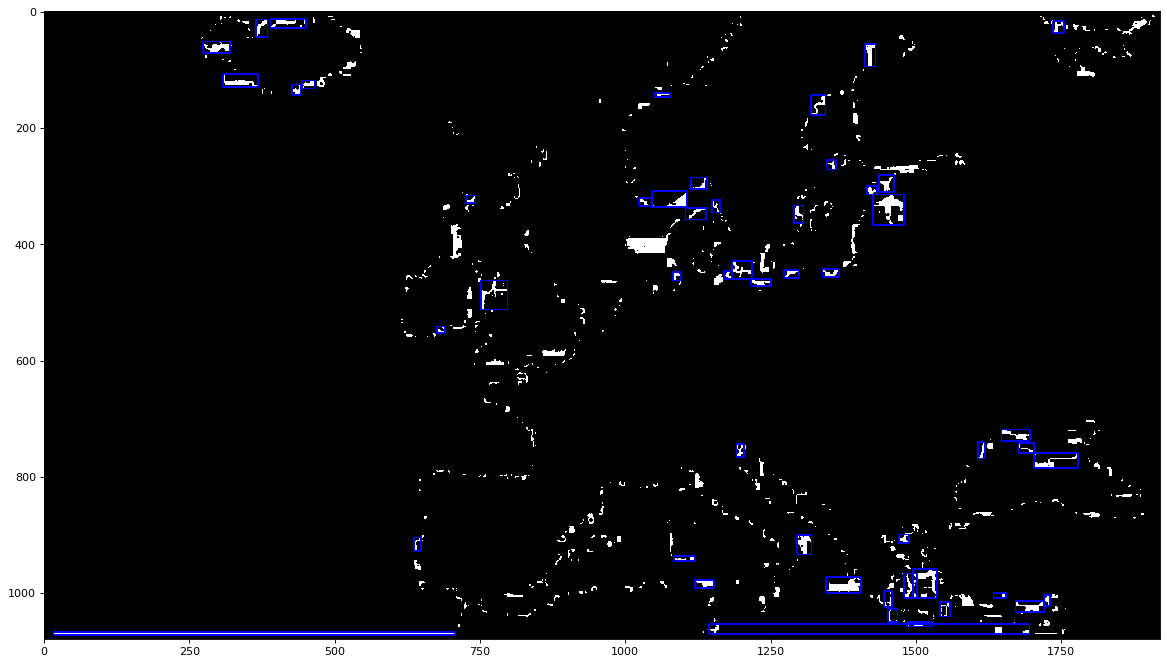

Kept  51 polygons
score 0.4358358934971838
score 0.36666666666666664
score 0.3776945560833029


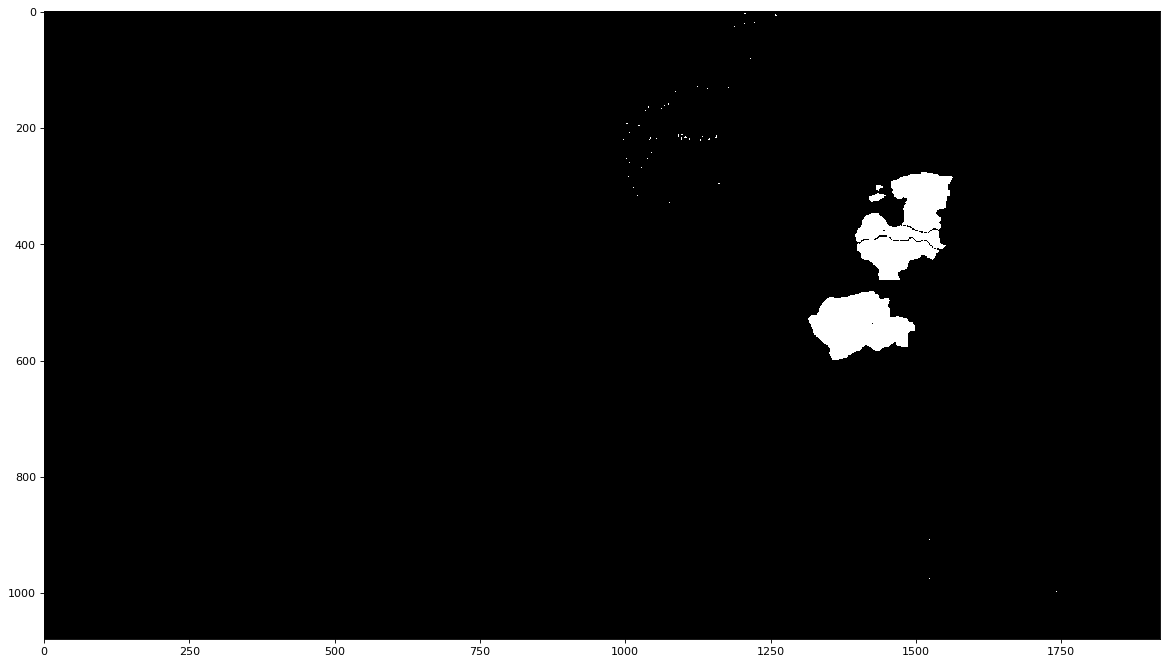

Kept  0 polygons
score 0.5753647864374508
score 0.575
score 0.47619047619047616
score 0.4138803418803419
score 0.583625730994152
score 0.42125


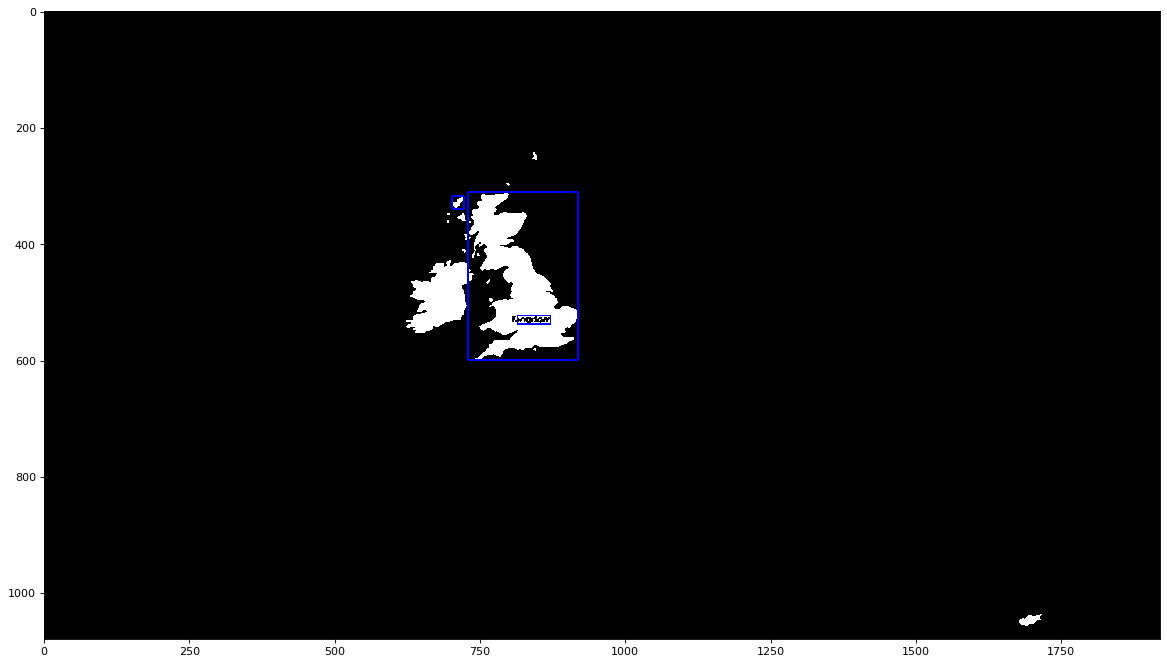

Kept  3 polygons
score 0.7392876489707476
score 0.40660681600278914
score 0.3233082706766917
score 0.47104247104247104


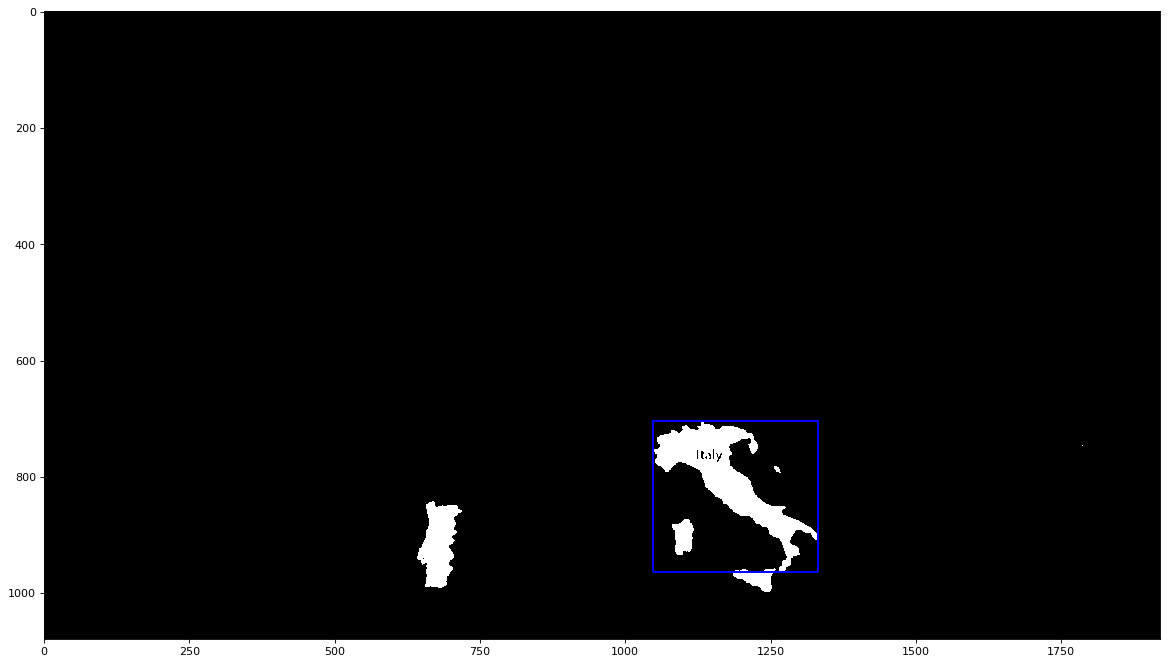

Kept  1 polygons
score 0.7374712643678161
score 0.8040838852097131
score 0.00949367088607595
score 0.5921052631578947
score 0.5
score 0.525
score 0.4258064516129032
score 0.6
score 0.3698224852071006
score 0.2809917355371901
score 0.43673469387755104
score 0.5
score 0.5770750988142292
score 0.5016233766233766
score 0.7379612257661038
score 0.43636363636363634
score 0.6736842105263158
score 0.5854545454545454
score 0.4365079365079365
score 0.4470899470899471
score 0.38164251207729466
score 0.6212121212121212
score 0.4523809523809524
score 0.5133928571428571
score 0.39915966386554624
score 0.3253968253968254
score 0.715625
score 0.569377990430622
score 0.4297520661157025
score 0.29545454545454547
score 0.5811688311688312
score 0.5784313725490197
score 0.6353276353276354
score 0.43125
score 0.5416666666666666
score 0.4236111111111111
score 0.3641304347826087
score 0.5942028985507246
score 0.6140350877192983
score 0.7359307359307359
score 0.37373737373737376
score 0.5170454545454546
score 

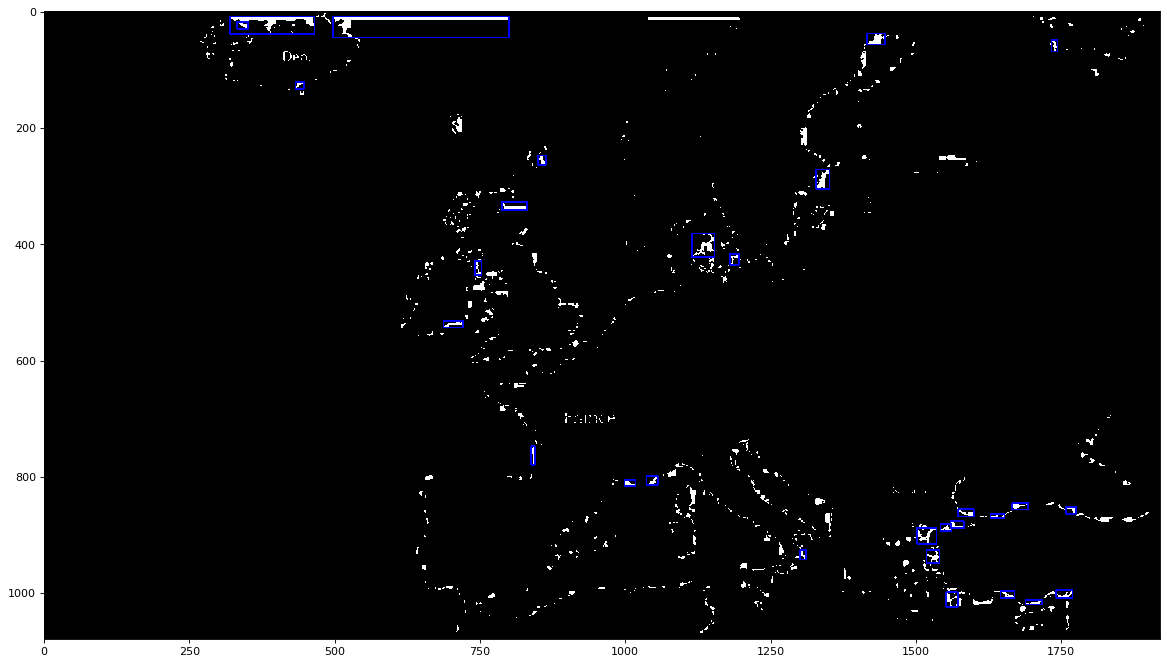

Kept  29 polygons
score 0.44023970037453186
score 0.12698412698412698
score 0.1452991452991453
score 0.46566597653554176
score 0.48348348348348347
score 0.2494279176201373
score 0.38235294117647056


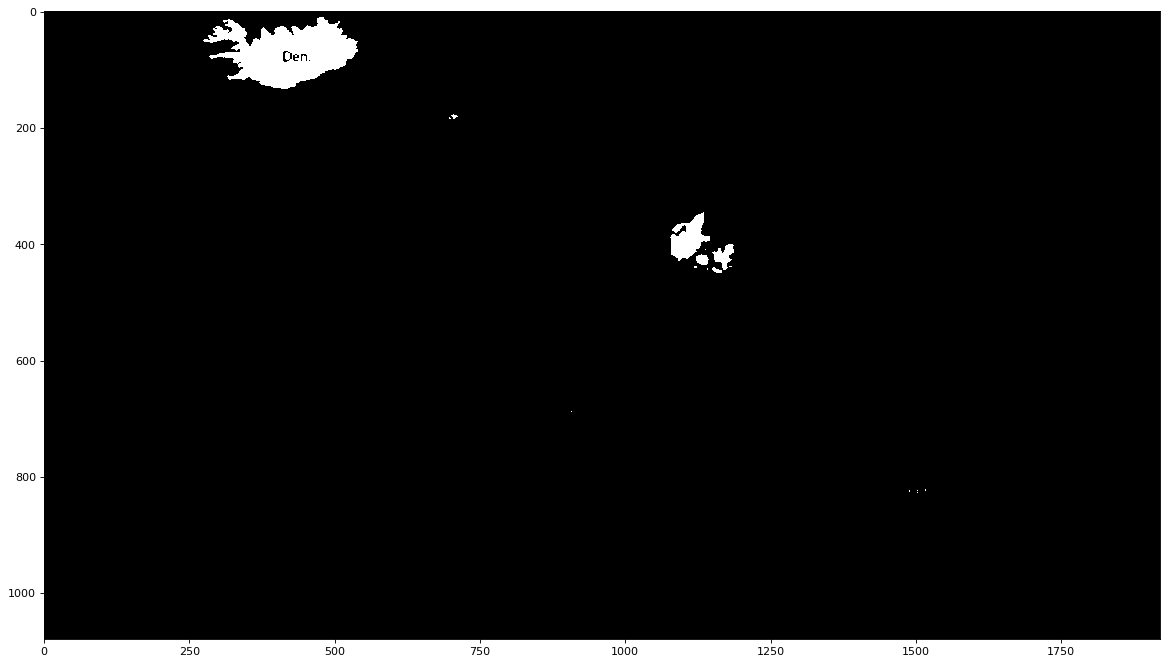

Kept  0 polygons
score 0.32200797872340425
score 0.23800112930547712
score 0.3


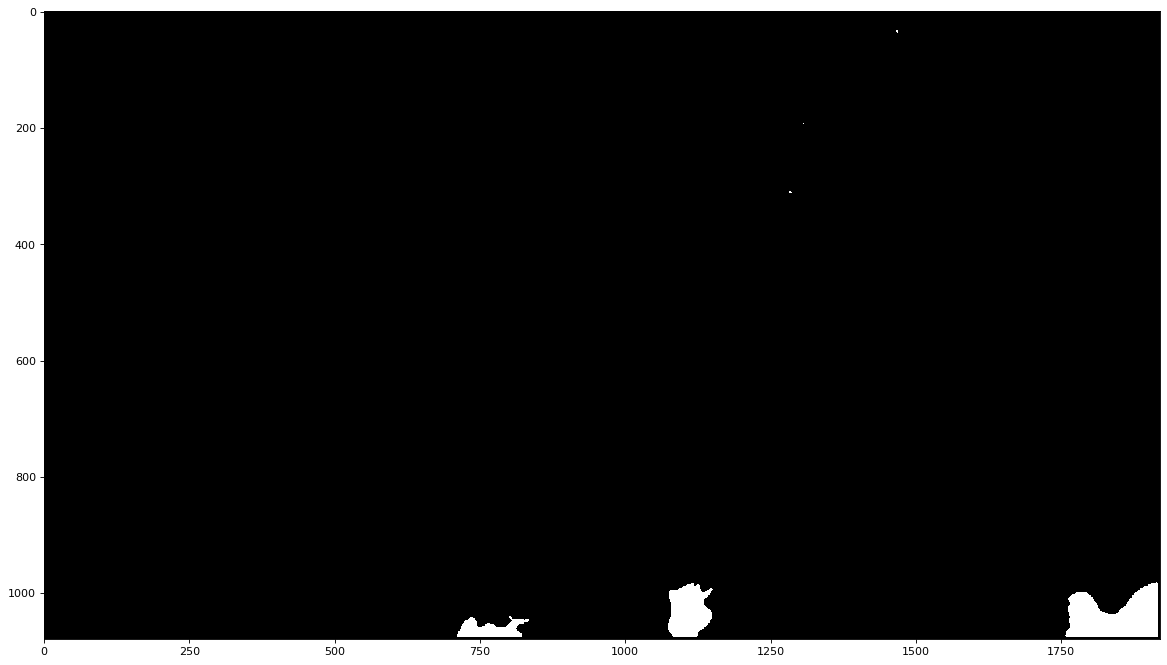

Kept  0 polygons
score 0.3134920634920635
score 0.49206349206349204
score 0.38492063492063494
score 0.6545454545454545
score 0.5703703703703704
score 0.5234375
score 0.6912393162393162
score 0.8128019323671497
score 0.798
score 0.7138888888888889
score 0.7852941176470588
score 0.7504244482173175
score 0.4962121212121212
score 0.634963768115942
score 0.684375
score 0.4251207729468599
score 0.5882352941176471
score 0.28888888888888886
score 0.575187969924812
score 0.4074074074074074


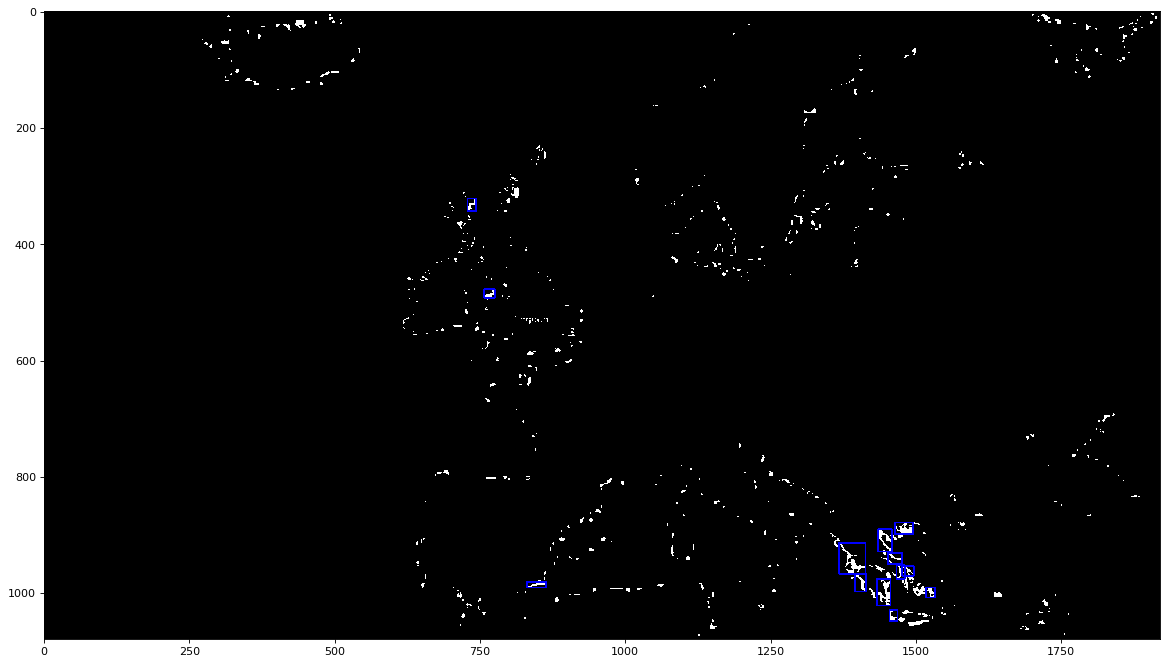

Kept  13 polygons
score 0.07910522800412897


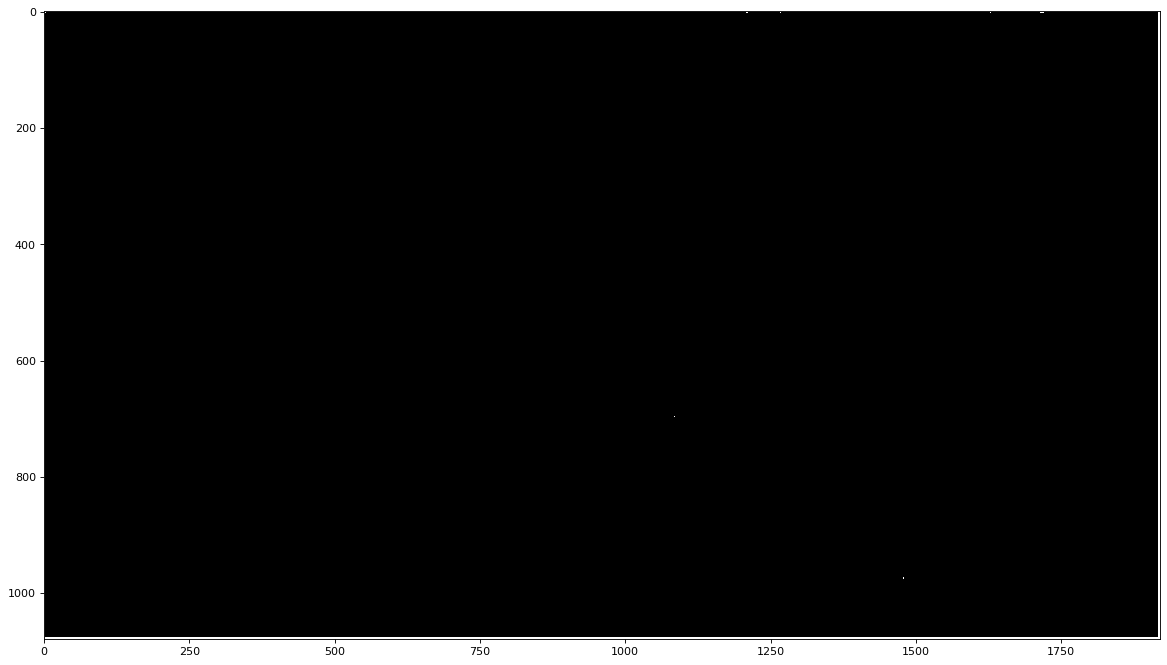

Kept  0 polygons
score 0.40490883590462834


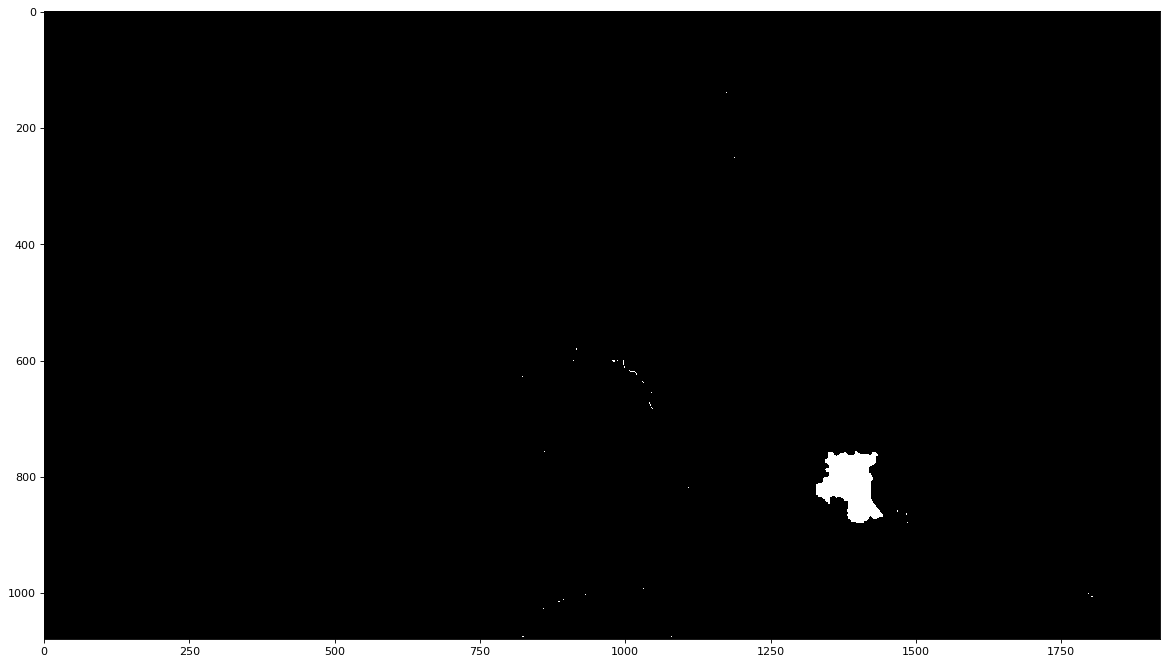

Kept  0 polygons


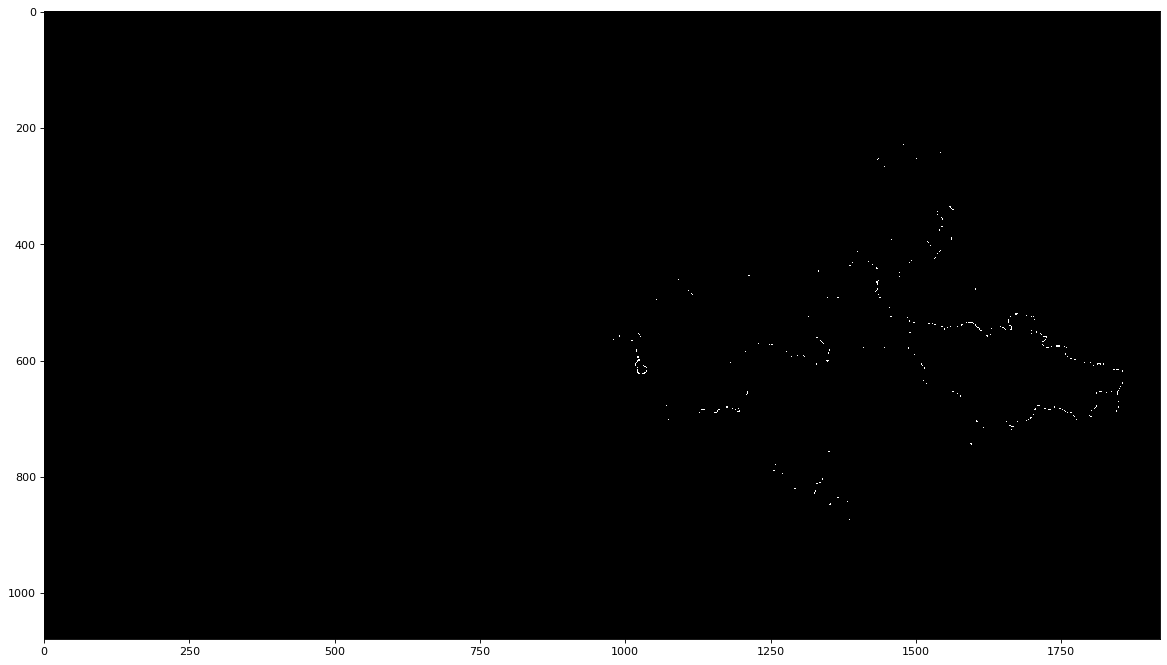

Kept  0 polygons


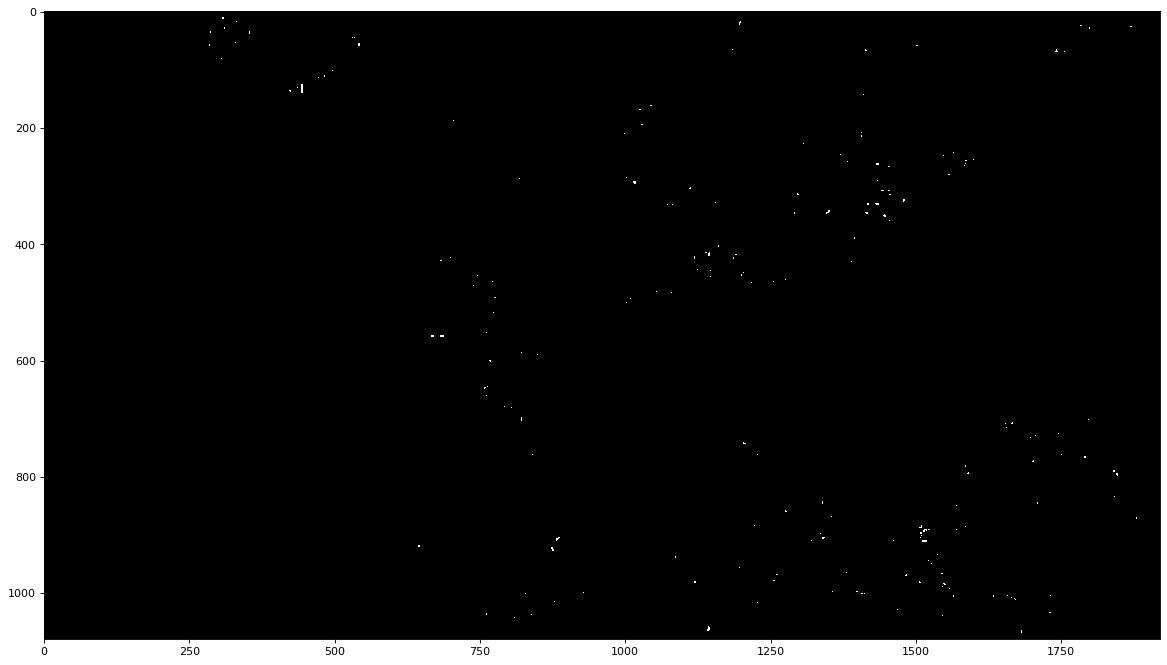

Kept  0 polygons


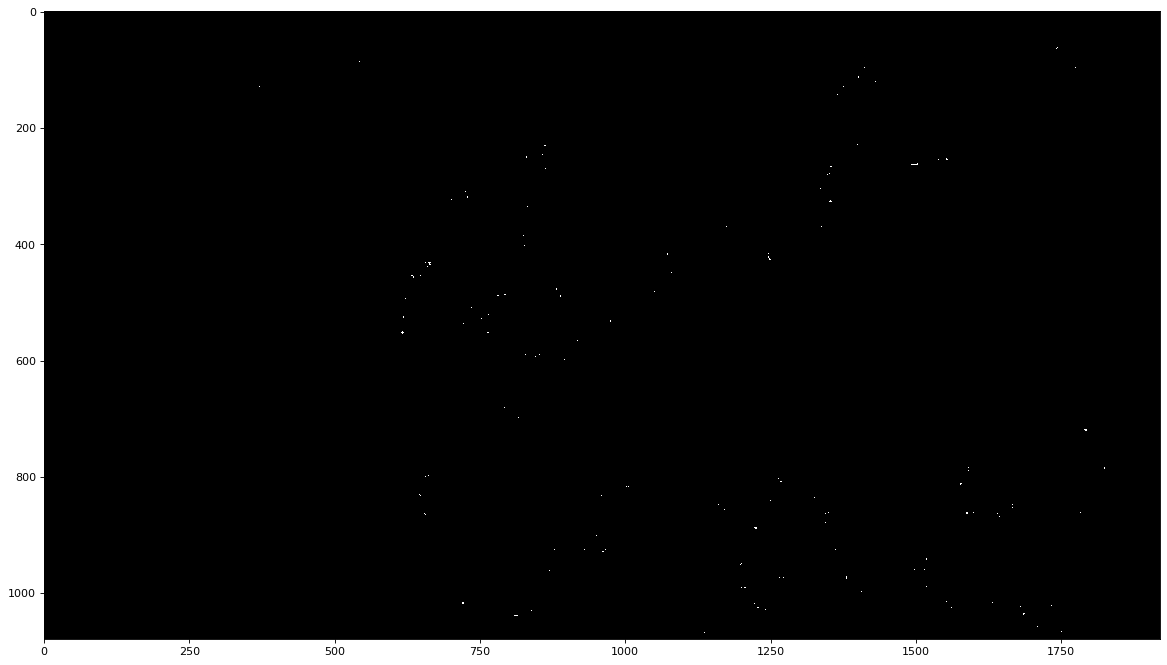

Kept  0 polygons
score 0.33116883116883117
score 0.19642857142857142
score 0.3333333333333333
score 0.18206521739130435
score 0.2271062271062271
score 0.22380952380952382
score 0.3317307692307692
score 0.2784090909090909


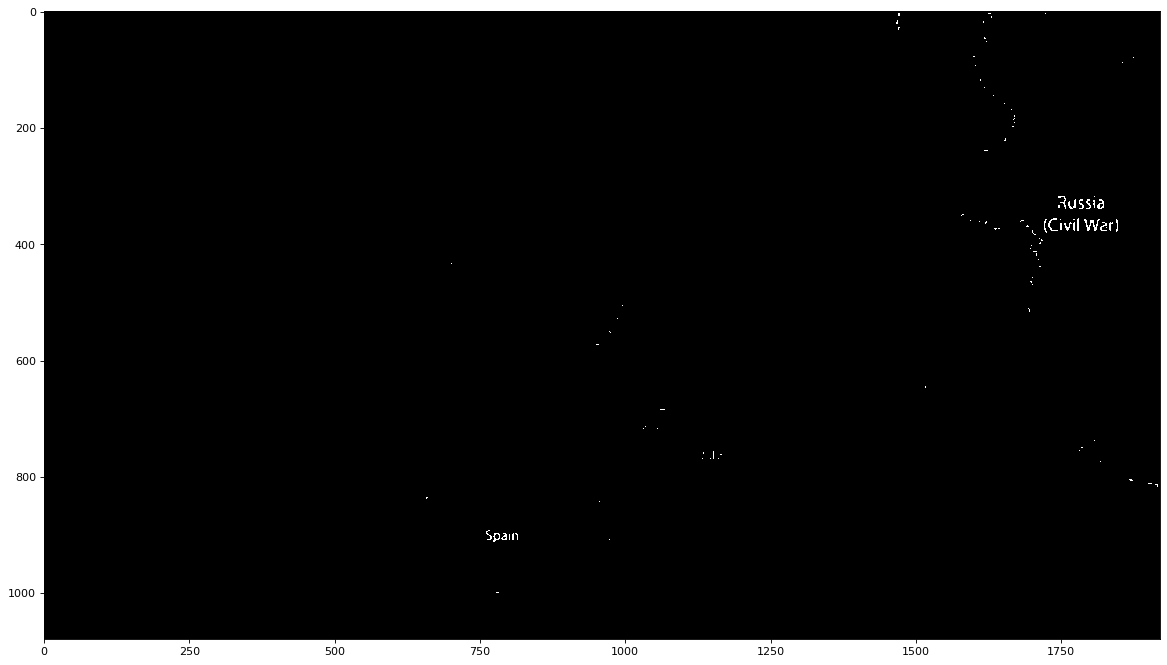

Kept  0 polygons


In [262]:
for mask in masks[:] :
    kept_polygons = filter_polygons(get_polygons(mask), mask)
    disp_polygons(skimage.color.gray2rgb(mask), kept_polygons)
    print('Kept ', len(kept_polygons), 'polygons')